# Contrat de maintenance

In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ks_2samp

import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.dates as mdates

In [3]:
# Charger le pipeline calibrée sur la période de référence
pipeline = joblib.load("pipeline_kmeans_reference.joblib")
df_reference = pd.read_csv("df_reference.csv")  # Période de référence déjà sauvegardée
df_final = pd.read_csv("df_final.csv")  # Période entière
print("Pipeline et DataFrame de référence chargés avec succès ")

Pipeline et DataFrame de référence chargés avec succès 


In [4]:
display(df_final.head())

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

  customer_state  recency  frequency  monetary  avg_review  avg_payment  \
0             SP      518          1    146.87         4.0       146.87   
1             SP      277          1    335.48         5.0       335.48   
2             SP      150          1    157.73         5.0       157.73   
3             SP      217          1    173.30         5.0       173.30   
4             SP       79          1    252.25         5.0       252.25   

   diversity_products  avg_installments      top_category  has_review  \
0                   1               2.0  office_furniture           1   
1                   1               8.0        housewares           1   
2                   1               7.0  office_furniture           1   
3                   1               1.0  office_furniture           1   
4                   1               8.0      home_confort           1   

  order_purchase_timestamp  
0               2017-05-16  
1               2018-01-12  
2               2018-05-19  
3               2018-03-13  
4               2018-07-29

In [5]:
cols_quant = [
    "recency",
    "monetary",
    "frequency",
    "avg_review",
    "avg_installments",
    "diversity_products",
]
cols_minmax = ["has_review"]
features = cols_quant + cols_minmax

In [6]:
display(df_final.columns)

Index(['customer_id', 'customer_unique_id', 'customer_state', 'recency',
       'frequency', 'monetary', 'avg_review', 'avg_payment',
       'diversity_products', 'avg_installments', 'top_category', 'has_review',
       'order_purchase_timestamp'],
      dtype='object')

## Période de référence

Rappel:

- X_reference_transformed est une matrice 2D contenant les données de la période de référence après transformation par la pipeline = représente les distances de chaque observation aux centres des clusters définis par le modèle: chaque ligne correspond à une observation, et les 5 colonnes indiquent la distance de cette observation à chacun des 5 centres de clusters.

- clusters_reference est un vecteur 1D où chaque élément correspond à un numéro de cluster attribué par KMeans à une observation donnée. Cela permet de savoir à quel cluster appartient chaque client après l'entraînement du modèle.

In [9]:
mask_reference = (df_final["order_purchase_timestamp"] >= "2016-09-04") & (
    df_final["order_purchase_timestamp"] <= "2017-12-31"
)
df_reference = df_final[mask_reference].copy()
df_reference_features = df_reference[features]
print("Aperçu des données de référence :")
print(df_reference.shape)

# Ici seulement transform car pipeline M0 a déjà été fit sur D0 lors du notebook Clustering
X_reference_transformed = pipeline.named_steps["preprocessor"].transform(
    df_reference_features
)
print("Shape de X_reference_transformed :", X_reference_transformed.shape)

# Predict pour affecter un Cluster à chaque observation
clusters_reference = pipeline.named_steps["kmeans"].predict(X_reference_transformed)
df_reference["Cluster_M0"] = clusters_reference

print("Vérification de la distribution des clusters M0 sur D0 :")
print(df_reference["Cluster_M0"].value_counts().sort_index())

Aperçu des données de référence :
(54958, 13)
Shape de X_reference_transformed : (54958, 7)
Vérification de la distribution des clusters M0 sur D0 :
Cluster_M0
0     8304
1    14656
2    21237
3     7712
4     3049
Name: count, dtype: int64


In [10]:
# Calcul des moyennes par cluster
cluster_means_original_reference = (
    df_reference.groupby("Cluster_M0")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_original_reference)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M0                                                              
0           422.765053   1.034562  516.733834    1.384453    1.000000   
1           535.317959   1.034252  227.870218    4.588974    0.990584   
2           357.701512   1.034139  222.309249    4.607282    0.989688   
3           430.510633   1.054201  930.430749    4.160043    0.984699   
4           341.576255   2.265005  578.345625    4.170790    0.987865   

            diversity_products  avg_installments  
Cluster_M0                                        
0                     1.028902          2.455383  
1                     1.005663          2.044965  
2                     1.000000          1.950464  
3                     1.018024          8.752107  
4                     2.141358          3.465531  


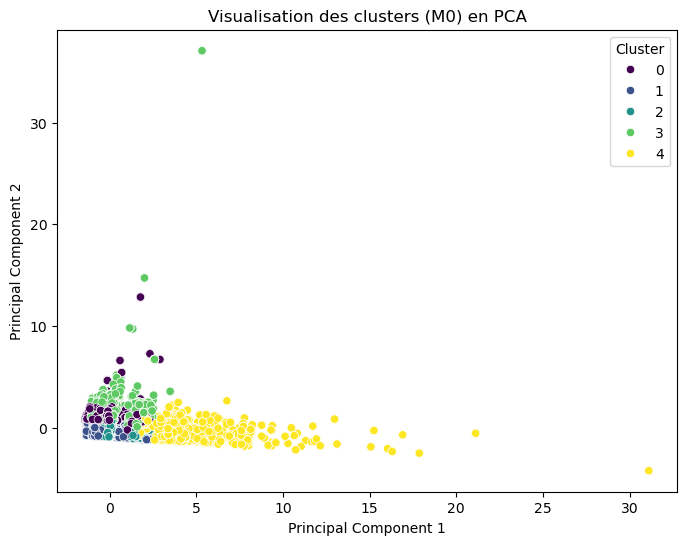

In [11]:
# Réduire la dimension pour visualiser en 2D
pca = PCA(n_components=2)
X_D0_pca = pca.fit_transform(X_reference_transformed)

# Créer une DataFrame pour la visualisation avec les 2 composantes principales
df_D0 = pd.DataFrame(X_D0_pca, columns=["PC1", "PC2"])
df_D0["Cluster_M0"] = (
    clusters_reference  # Remplace clusters_reference par le nom correct
)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_D0, x="PC1", y="PC2", hue="Cluster_M0", palette="viridis")
plt.title("Visualisation des clusters (M0) en PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

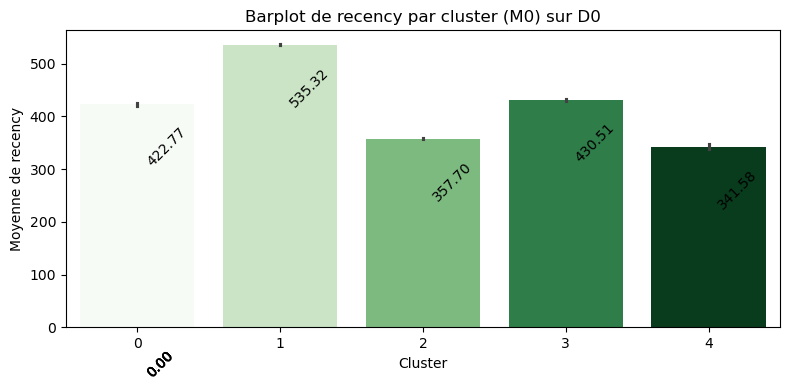

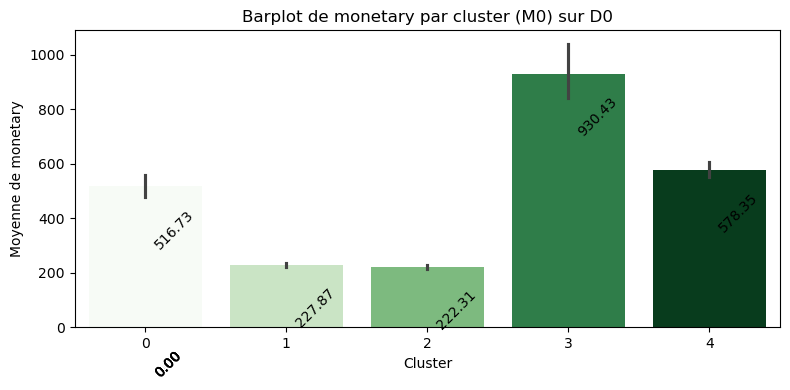

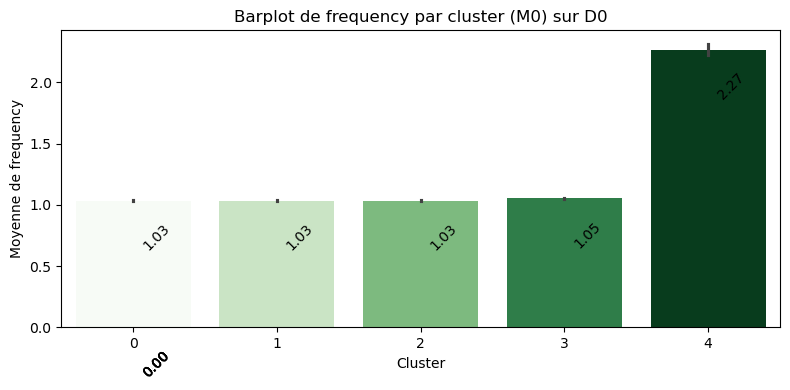

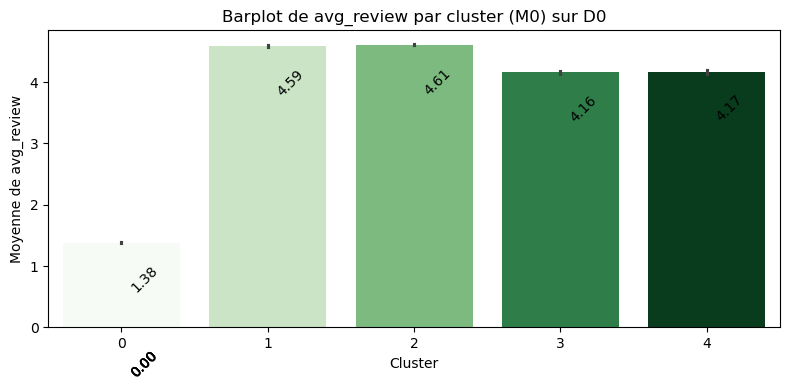

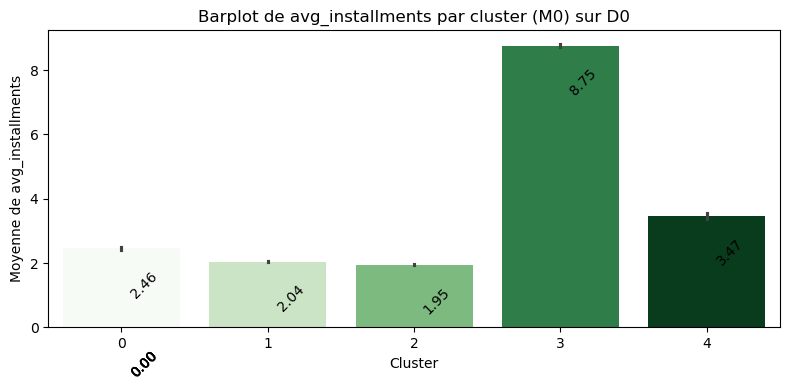

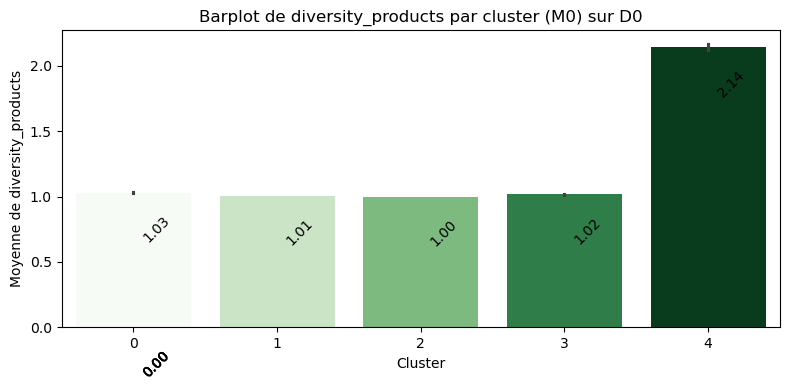

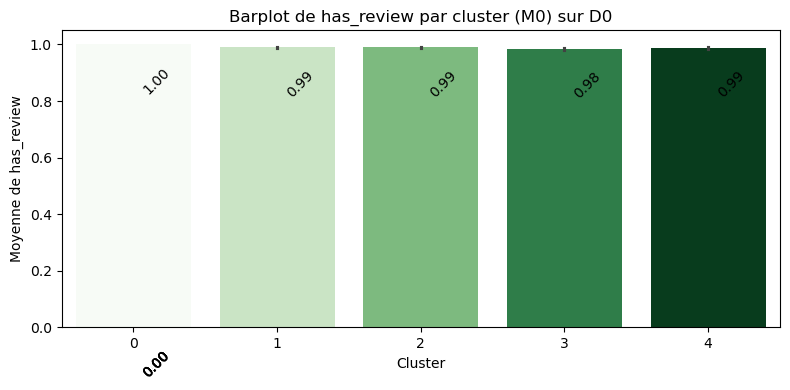

In [12]:
for feature in features:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        data=df_reference,
        x="Cluster_M0",
        y=feature,
        hue="Cluster_M0",
        palette="Greens",
        dodge=False,
    )

    plt.title(f"Barplot de {feature} par cluster (M0) sur D0")
    plt.xlabel("Cluster")
    plt.ylabel(f"Moyenne de {feature}")

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="left",
            va="top",
            fontsize=10,
            color="black",
            xytext=(5, -15),
            textcoords="offset points",
            rotation=45,
        )

    ax.legend_.remove()  # Supprime la légende automatique si inutile
    plt.tight_layout()
    plt.show()

### ARI 

In [14]:
ari_M0M0 = adjusted_rand_score(df_reference["Cluster_M0"], df_reference["Cluster_M0"])
print(f"ARI entre M0 et M0 sur D0 : {ari_M0M0:.4f}")

ARI entre M0 et M0 sur D0 : 1.0000


## **Méthodologie suivie pour le contrat de maintenance:**

1. Création d'une nouvelle période du 04/09/2016 au 28/02/2018: **Fit ET transform** du nouveau modèle M1 sur D1. Donc on recalibre la pipeline (prenant en compte les nouveaux clients ou l’évolution des comportements) sur la nouvelle période.
2. Applique uniquement la transformation (sans recalibrer) du modèle M0 sur D1 afin d’obtenir les clusters selon la référence.
3. Comparaison des clusters entre M1D1 et M0D1 avec l'ARI pour voir l'évolution des comportements clients.
4. Utilisation de visualisations pour l'évolution des distributions des features et utilisation du test de Kolmogorov-Smirnov pour comparer la distribution de chaque feature.
5. En fonction de l’ARI et des résultats des tests statistiques (p-value), définis un seuil critique (par exemple, ARI < X ou KS p-value < 0.05) qui déclenchera le réentraînement du modèle.
6. Itération des 4 étapes ci dessus en ajoutant 2 mois à la période à chaque fois.

- Période référence: 4/09/2016 - 31/12/2017
- Période 1: 04/09/2016 - 28/02/2018
- Période 2: 04/09/2016 - 30/04/2018
- Période 3: 04/09/2016 - 30/06/2018
- Période 4: 04/09/2016 - 31/08/2018
- Période 5: 04/09/2016 - 17/10/2018

## Création d'une fonction pour Pipeline

In [17]:
def build_pipeline():
    """
    Crée et retourne une nouvelle instance de pipeline pour la segmentation par clustering.

    Cette fonction construit une pipeline qui se compose de deux étapes :

      1. Préprocesseur :
         - Un ColumnTransformer qui applique une standardisation (StandardScaler)
           aux colonnes quantitatives définies dans la variable globale `cols_quant`.
         - L'autre colonne 'has_review' est laissée inchangée
           grâce à l'option `remainder='passthrough'`.

      2. Modèle de clustering :
         - Un algorithme KMeans configuré pour identifier 5 clusters.
         - Il utilise l'initialisation "k-means++", l'option `n_init="auto"` pour
           définir automatiquement le nombre d'initialisations, et un `random_state`
           fixé pour assurer la reproductibilité des résultats.

    Retourne :
        pipeline: Une instance entièrement configurée pour prétraiter les données et appliquer le clustering.
    """
    # Création du préprocesseur pour standardiser les colonnes quantitatives
    preprocessor = ColumnTransformer(
        transformers=[("std_scaler", StandardScaler(), cols_quant)],
        remainder="passthrough",  # Les autres colonnes ne sont pas modifiées
    )

    # Construction de la pipeline incluant le préprocesseur et le modèle de clustering
    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            (
                "kmeans",
                KMeans(n_clusters=5, init="k-means++", n_init="auto", random_state=42),
            ),
        ],
        verbose=True,
    )

    return pipeline

## Période 1: 04/09/2016 au 28/02/2018

### a. Sélection de la période

In [20]:
# Sélectionner la période 1
mask_D1 = (df_final["order_purchase_timestamp"] >= "2016-09-04") & (
    df_final["order_purchase_timestamp"] <= "2018-02-28"
)
df_D1 = df_final[mask_D1].copy()
df_D1_features = df_D1[features]

# Vérification
print("Shape des données D1 :", df_D1.shape)

Shape des données D1 : (71670, 13)


### b. Lancement du modèle

In [22]:
# 1. Application de M0 sur D1 (seulement transformation), utilisation de la pipeline déjà fit sur D0
# Comment le modèle M0, appris sur D0, se comporte sur une période plus étendue (D1).

X_D1_transformed_M0 = pipeline.named_steps["preprocessor"].transform(df_D1_features)

# Vérification
print("Shape de X_D1_transformed_M0 :", X_D1_transformed_M0.shape)

clusters_D1_M0 = pipeline.named_steps["kmeans"].predict(X_D1_transformed_M0)
df_D1["Cluster_M0"] = clusters_D1_M0

# Vérification
print("Distribution des clusters M0 sur D1 :")
print(df_D1["Cluster_M0"].value_counts().sort_index())

Shape de X_D1_transformed_M0 : (71670, 7)
Distribution des clusters M0 sur D1 :
Cluster_M0
0    11323
1    14656
2    32611
3     9180
4     3900
Name: count, dtype: int64


In [23]:
# Fit transform de la pipeline M1 sur D1 avec la fonction build_pipeline
pipeline_M1 = build_pipeline()
X_D1_transformed_M1 = pipeline_M1.fit_transform(df_D1_features)
clusters_D1_M1 = pipeline_M1.named_steps["kmeans"].labels_
df_D1["Cluster_M1"] = clusters_D1_M1

# Vérification
print("Distribution des clusters M1 sur D1 :")
print(df_D1["Cluster_M1"].value_counts().sort_index())

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.2s
Distribution des clusters M1 sur D1 :
Cluster_M1
0    15185
1    11126
2     3966
3      157
4    41236
Name: count, dtype: int64


La construction des clusters a beaucoup changé entre M0 et M1en particulier pour les Clusters 2, 3 et 4

### c. Visualisations

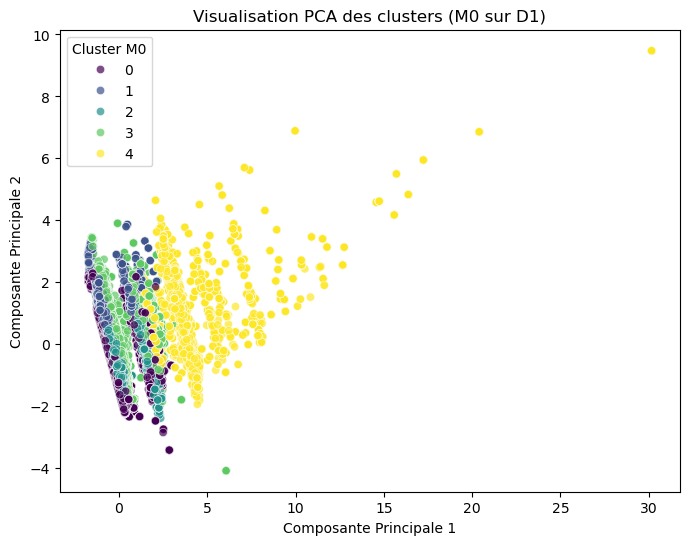

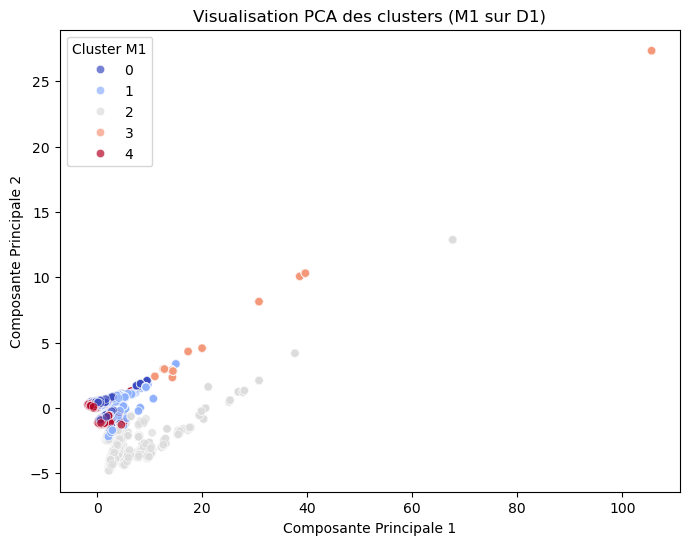

In [26]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D1_pca_M0 = pca.fit_transform(X_D1_transformed_M0)
X_D1_pca_M1 = pca.fit_transform(X_D1_transformed_M1)

# Création d'un DataFrame pour la visualisation
df_D1_pca_M0 = pd.DataFrame(X_D1_pca_M0, columns=["PC1", "PC2"])
df_D1_pca_M0["Cluster_M0"] = clusters_D1_M0

df_D1_pca_M1 = pd.DataFrame(X_D1_pca_M1, columns=["PC1", "PC2"])
df_D1_pca_M1["Cluster_M1"] = clusters_D1_M1  # Ajout des clusters

# Affichage des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_D1_pca_M0, x="PC1", y="PC2", hue="Cluster_M0", palette="viridis", alpha=0.7
)
plt.title("Visualisation PCA des clusters (M0 sur D1)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Cluster M0")


# Affichage des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_D1_pca_M1, x="PC1", y="PC2", hue="Cluster_M1", palette="coolwarm", alpha=0.7
)
plt.title("Visualisation PCA des clusters (M1 sur D1)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Cluster M1")


plt.show()

In [27]:
cluster_means_M0D1 = (
    df_D1.groupby("Cluster_M0")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M0D1)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M0                                                              
0           378.026583   1.036563  599.984647    1.333398    1.000000   
1           535.317959   1.034252  227.870218    4.588974    0.990584   
2           323.160590   1.033946  219.300631    4.580699    0.989022   
3           402.846732   1.055991  913.823849    4.130292    0.985512   
4           316.118462   2.263846  628.840962    4.137760    0.988718   

            diversity_products  avg_installments  
Cluster_M0                                        
0                     1.025877          2.444302  
1                     1.005663          2.044965  
2                     1.000000          1.954174  
3                     1.018519          8.784207  
4                     2.133590          3.363077  


- Cluster 0: clients insatisfaits
- Cluster 1: clients inactifs (très satisfaits)
- Cluster 2: clients le moins dépensiers (très satisfaits)
- Cluster 3: clients le plus dépensiers et avec le plus d'échelonnage
- Cluster 4: clients achètent le plus fréquemment et le plus de types de produtis

In [29]:
cluster_means_M1D1 = (
    df_D1.groupby("Cluster_M1")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M1D1)

               recency  frequency      monetary  avg_review  has_review  \
Cluster_M1                                                                
0           375.581824   1.035561    366.064964    1.783028    1.000000   
1           410.353856   1.052220    572.188873    4.164173    0.988226   
2           320.604892   2.247857    630.342030    4.153117    0.988906   
3           332.681529   1.337580  31172.354331    2.261146    0.872611   
4           388.084271   1.032569    213.585741    4.742372    0.988408   

            diversity_products  avg_installments  
Cluster_M1                                        
0                     1.018373          2.219142  
1                     1.017167          8.267189  
2                     2.128845          3.325517  
3                     1.063694          3.676858  
4                     1.000243          1.835429  


- Cluster 0: Clients insatisfaits
- Cluster 1: clients inactifs **similaire au M0** mais avec le plus d'échelonnage **différent de M0**
- Cluster 2: Clients les plus fréquents **différent de M0**
- Cluster 3: Clients les plus dépensiers **similarité avec M0**
- Cluster 4: Clients les plus satisfaits dépensant le moins **différent de M0**

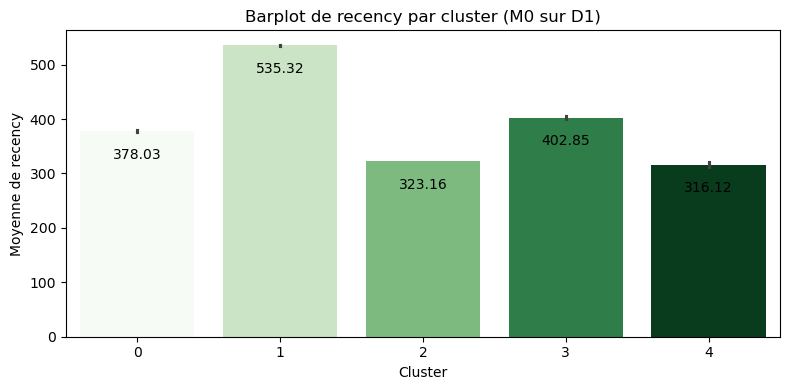

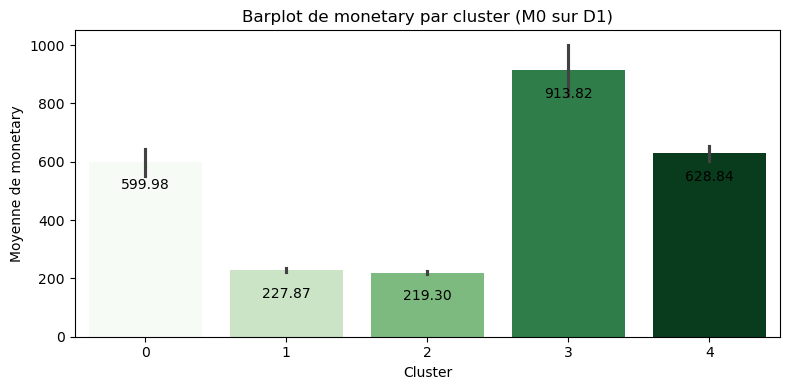

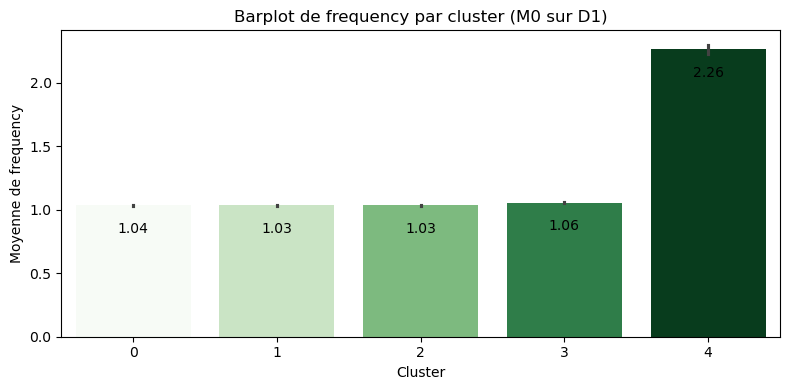

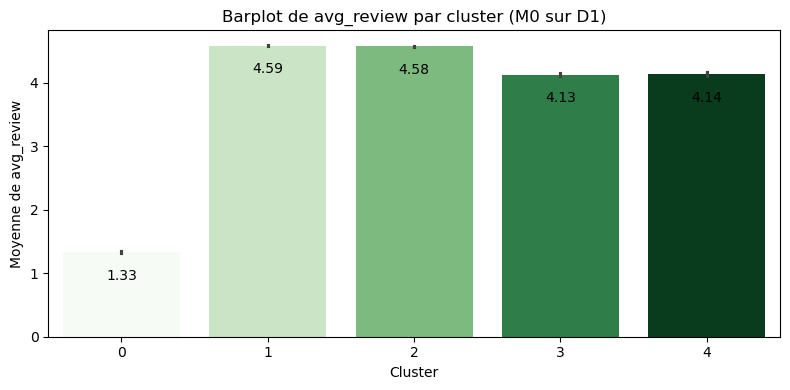

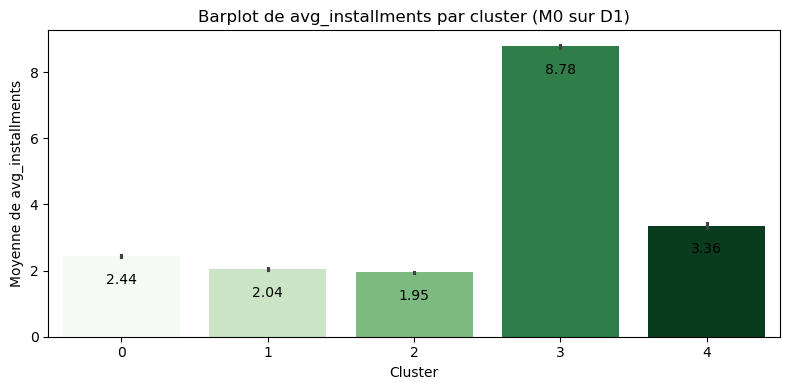

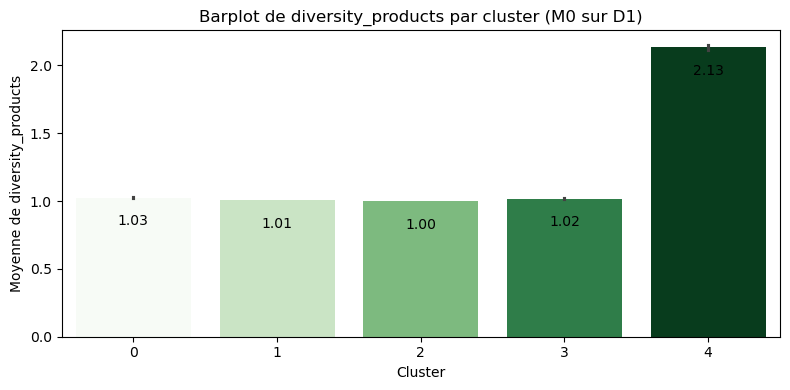

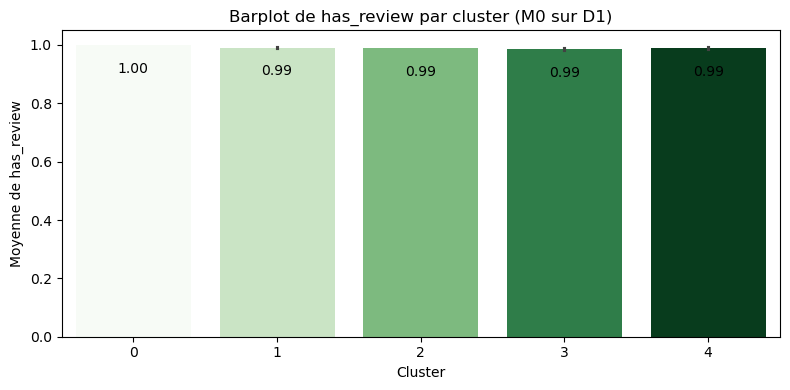

In [31]:
# M0 sur D1

for feature in features:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        data=df_D1,
        x="Cluster_M0",
        y=feature,
        hue="Cluster_M0",
        palette="Greens",
        legend=False,
    )
    plt.title(f"Barplot de {feature} par cluster (M0 sur D1)")
    plt.xlabel("Cluster")
    plt.ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=10,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

    plt.tight_layout()
    plt.show()

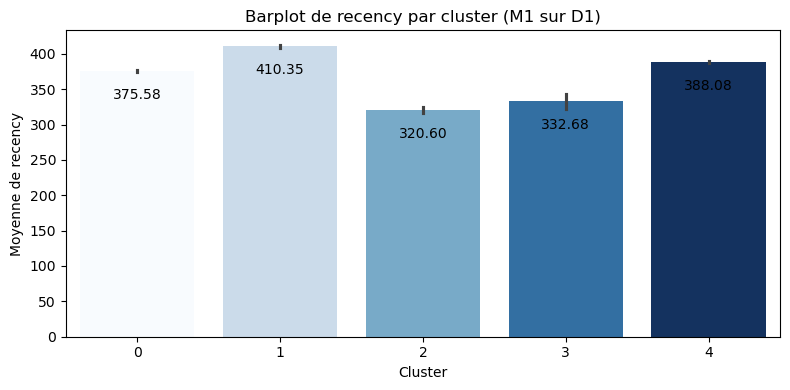

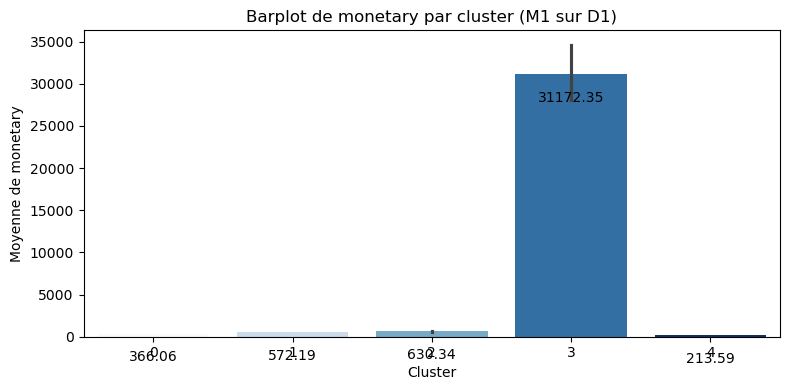

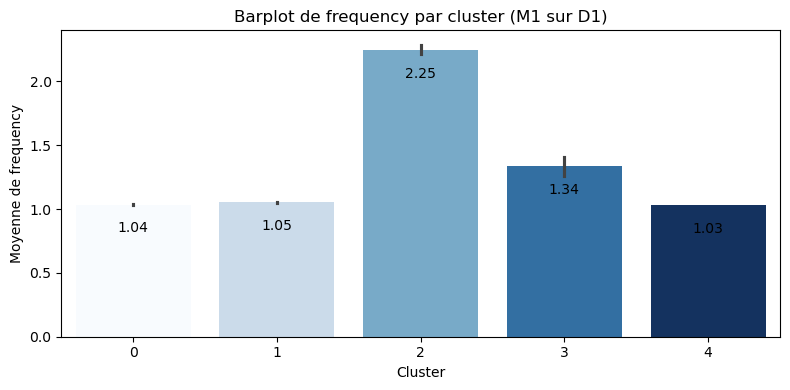

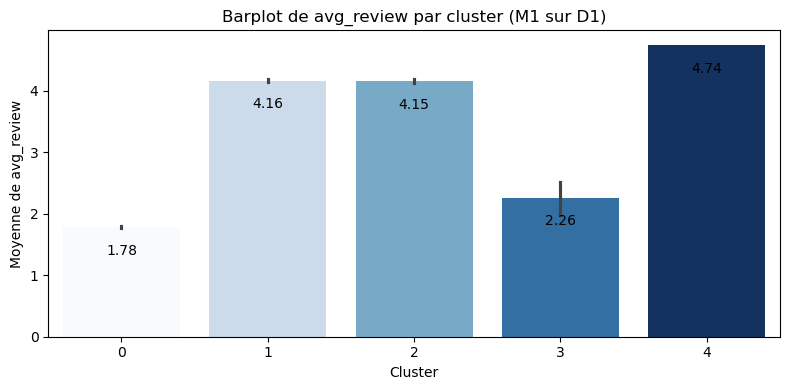

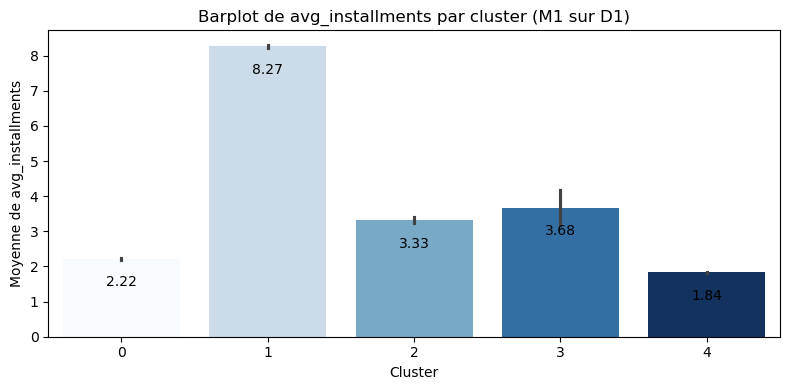

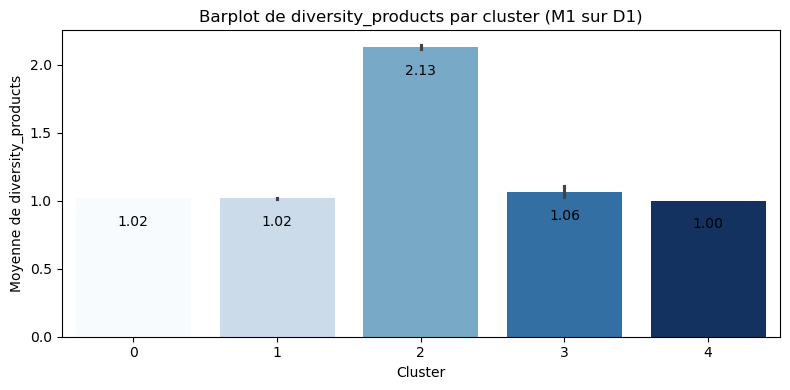

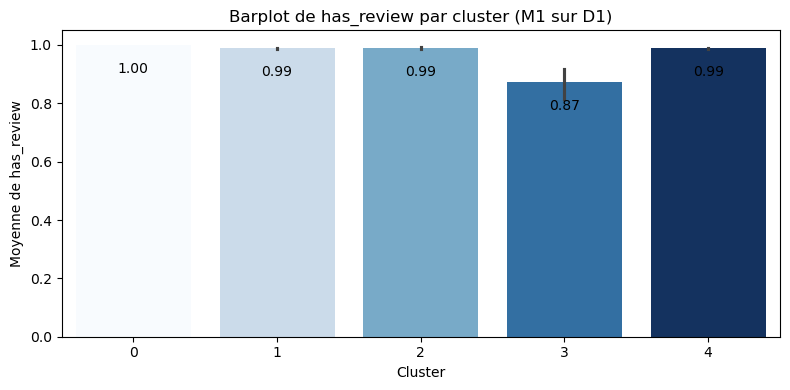

In [32]:
# M1 sur D1

for feature in features:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        data=df_D1,
        x="Cluster_M1",
        y=feature,
        hue="Cluster_M1",
        palette="Blues",
        legend=False,
    )
    plt.title(f"Barplot de {feature} par cluster (M1 sur D1)")
    plt.xlabel("Cluster")
    plt.ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=10,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

    plt.tight_layout()
    plt.show()

### d. ARI

Rappel: L'Adjusted Rand Index (ARI) est une métrique qui mesure la similarité entre deux partitions (deux attributions de clusters) en prenant en compte le hasard. Il varie entre -1 et 1 :

- ARI = 1 => Les deux partitions sont identiques (chaque client a été classé exactement dans le même cluster dans les deux périodes).
- ARI = 0 => La partition est aléatoire, pas meilleure que du hasard.
- ARI < 0 => Les clusters sont moins bien que du hasard, ce qui est rare en pratique

- Pour utiliser l'ARI il faut absolument faire la comparaison sur les clients communs aux deux périodes

In [35]:
# 3. Calcul de l'ARI entre M0 et M1 sur D1
ari_M0M1 = adjusted_rand_score(df_D1["Cluster_M0"], df_D1["Cluster_M1"])
print(f"ARI entre M0 et M1 sur D1 : {ari_M0M1:.4f}")

ARI entre M0 et M1 sur D1 : 0.5160


### e. Test de Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov permet de comparer si deux distributions sont significativement différentes.

- p-value > 0.05 : On ne rejette pas l’hypothèse que les distributions sont similaires (pas de changement significatif).
- p-value < 0.05 : On rejette l’hypothèse de similarité, donc la distribution a changé entre les périodes.

Ici , permet de voir si les distributions des variables au sein des clusters ont changé entre M0D1 et M1D1. Est-ce que chaque cluster contient encore les mêmes types d'observations ? Ou bien les clusters ont-ils changé de nature, en regroupant des profils différents ?
Si les distributions sont similaires = les clusters ont juste été renommés ou réorganisés.
Si elles sont différentes = la nature des clusters a changé, donc l’algorithme a trouvé de nouvelles structures dans les données.


In [38]:
n_clusters = 5

# Initialisation des résultats
ks_results = {}

print("\nComparaison des distributions par cluster entre M0D1 et M1D1 :")
for cluster in range(n_clusters):  # Boucle sur chaque cluster
    print(f"\n Comparaison pour le Cluster {cluster} :")

    # Filtrer les données pour chaque cluster
    df_D1_M0_cluster = df_D1[df_D1["Cluster_M0"] == cluster]
    df_D1_M1_cluster = df_D1[df_D1["Cluster_M1"] == cluster]

    for feature in features:  # Boucle sur chaque feature
        if (
            len(df_D1_M0_cluster) > 0 and len(df_D1_M1_cluster) > 0
        ):  # Vérifier que le cluster existe bien
            stat, p_value = ks_2samp(
                df_D1_M0_cluster[feature], df_D1_M1_cluster[feature]
            )
            ks_results[(cluster, feature)] = {"KS Statistic": stat, "p-value": p_value}

            print(f"Feature: {feature}")
            print(f"  -> KS Statistic: {stat:.4f}")
            print(f"  -> p-value: {p_value:.4f}")
            if p_value < 0.05:
                print(
                    " La distribution est significativement différente entre M0D1 et M1D1."
                )
            else:
                print(" Aucune différence significative entre M0D1 et M1D1.")
            print("-" * 50)
        else:
            print(
                f" Cluster {cluster} inexistant dans l'un des modèles. Vérification nécessaire."
            )


Comparaison des distributions par cluster entre M0D1 et M1D1 :

 Comparaison pour le Cluster 0 :
Feature: recency
  -> KS Statistic: 0.0299
  -> p-value: 0.0000
 La distribution est significativement différente entre M0D1 et M1D1.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.0444
  -> p-value: 0.0000
 La distribution est significativement différente entre M0D1 et M1D1.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0009
  -> p-value: 1.0000
 Aucune différence significative entre M0D1 et M1D1.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.2494
  -> p-value: 0.0000
 La distribution est significativement différente entre M0D1 et M1D1.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0409
  -> p-value: 0.0000
 La distribution est significativement différente entre M0D1 et M1D1.
------------------------------

- Tous les clusters montrent des différences significatives pour au moins 4 features.
- Le Cluster 3 a des écarts très forts, notamment sur monetary (0.99), avg_review (0.54) et avg_installments (0.74).
- Les Clusters 2 et 4 montrent aussi des différences massives sur plusieurs features.

  
Quelques similarités malgré tout :
- has_review ne change presque jamais (sauf Cluster 3).
- diversity_products est parfois stable (Clusters 0 et 3).


## Période 2 : 04/09/2016 au 30/04/2018

### a. Sélection de la période

In [42]:
# Sélectionner la période 2
mask_D2 = (df_final["order_purchase_timestamp"] >= "2016-09-04") & (
    df_final["order_purchase_timestamp"] <= "2018-04-30"
)
df_D2 = df_final[mask_D2].copy()
df_D2_features = df_D2[features]

# Vérification
print("Shape des données D2 :", df_D2.shape)

Shape des données D2 : (88562, 13)


### b. Lancement du modèle

In [44]:
# 1. Application de M0 sur D2 (seulement transformation)

# Appliquer la transformation de M0 sur D2
X_D2_transformed_M0 = pipeline.named_steps["preprocessor"].transform(df_D2_features)
# Vérification
print("Shape de X_D2_transformed_M0 :", X_D2_transformed_M0.shape)

# Prédiction des clusters avec M0
clusters_D2_M0 = pipeline.named_steps["kmeans"].predict(X_D2_transformed_M0)
df_D2["Cluster_M0"] = clusters_D2_M0

# Vérification
print("Distribution des clusters M0 sur D2 :")
print(df_D2["Cluster_M0"].value_counts().sort_index())

Shape de X_D2_transformed_M0 : (88562, 7)
Distribution des clusters M0 sur D2 :
Cluster_M0
0    14190
1    14656
2    44348
3    10692
4     4676
Name: count, dtype: int64


In [45]:
# 1. Application de M1 sur D2 (seulement transformation)

# Appliquer la transformation de M1 sur D2
X_D2_transformed_M1 = pipeline_M1.named_steps["preprocessor"].transform(df_D2_features)
# Vérification
print("Shape de X_D2_transformed_M1 :", X_D2_transformed_M1.shape)

# Prédiction des clusters avec M1
clusters_D2_M1 = pipeline_M1.named_steps["kmeans"].predict(X_D2_transformed_M1)
df_D2["Cluster_M1"] = clusters_D2_M1

# Vérification
print("Distribution des clusters M1 sur D2 :")
print(df_D2["Cluster_M1"].value_counts().sort_index())

Shape de X_D2_transformed_M1 : (88562, 7)
Distribution des clusters M1 sur D2 :
Cluster_M1
0    19244
1    13251
2     4703
3      171
4    51193
Name: count, dtype: int64


In [46]:
# 2. Création et fit du nouveau modèle M2 sur D2

# Fit de la pipeline M2 sur D2
pipeline_M2 = build_pipeline()
X_D2_transformed_M2 = pipeline_M2.fit_transform(df_D2_features)
clusters_D2_M2 = pipeline_M2.named_steps["kmeans"].labels_
df_D2["Cluster_M2"] = clusters_D2_M2

# Vérification
print("Distribution des clusters M2 sur D2 :")
print(df_D2["Cluster_M2"].value_counts().sort_index())

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
Distribution des clusters M2 sur D2 :
Cluster_M2
0    35192
1    11682
2    22467
3     4556
4    14665
Name: count, dtype: int64


### c. Visualisations

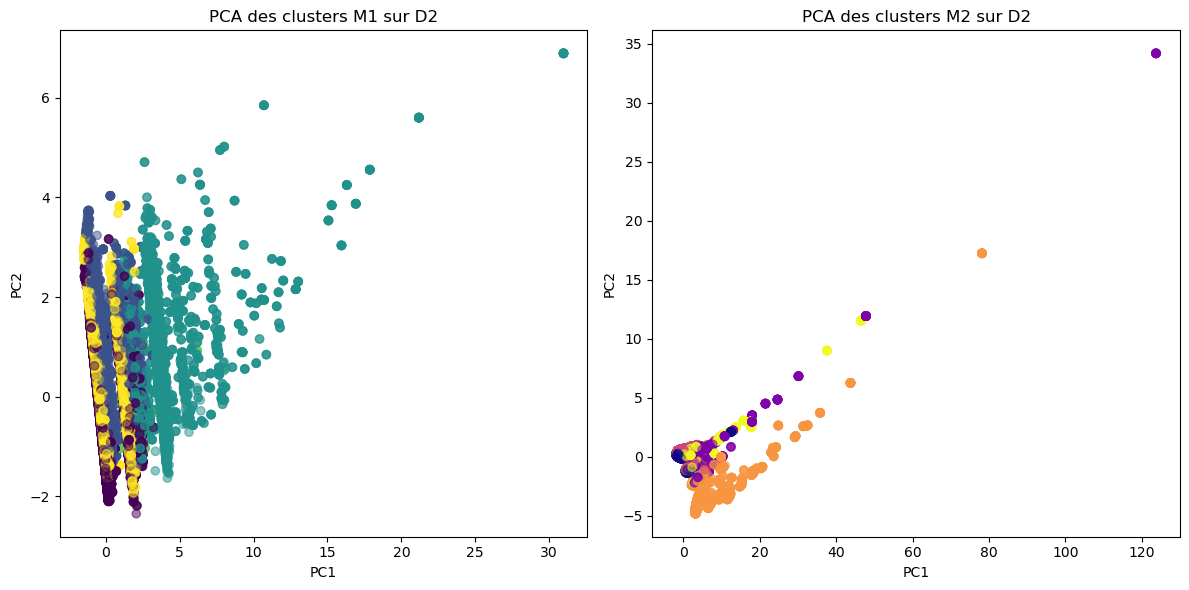

In [48]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D2_pca_M1 = pca.fit_transform(X_D2_transformed_M1)
X_D2_pca_M2 = pca.fit_transform(X_D2_transformed_M2)

# Scatterplot des clusters M1 sur D2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D2_pca_M1[:, 0],
    X_D2_pca_M1[:, 1],
    c=df_D2["Cluster_M1"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M1 sur D2")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M2 sur D2
plt.subplot(1, 2, 2)
plt.scatter(
    X_D2_pca_M2[:, 0],
    X_D2_pca_M2[:, 1],
    c=df_D2["Cluster_M2"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M2 sur D2")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

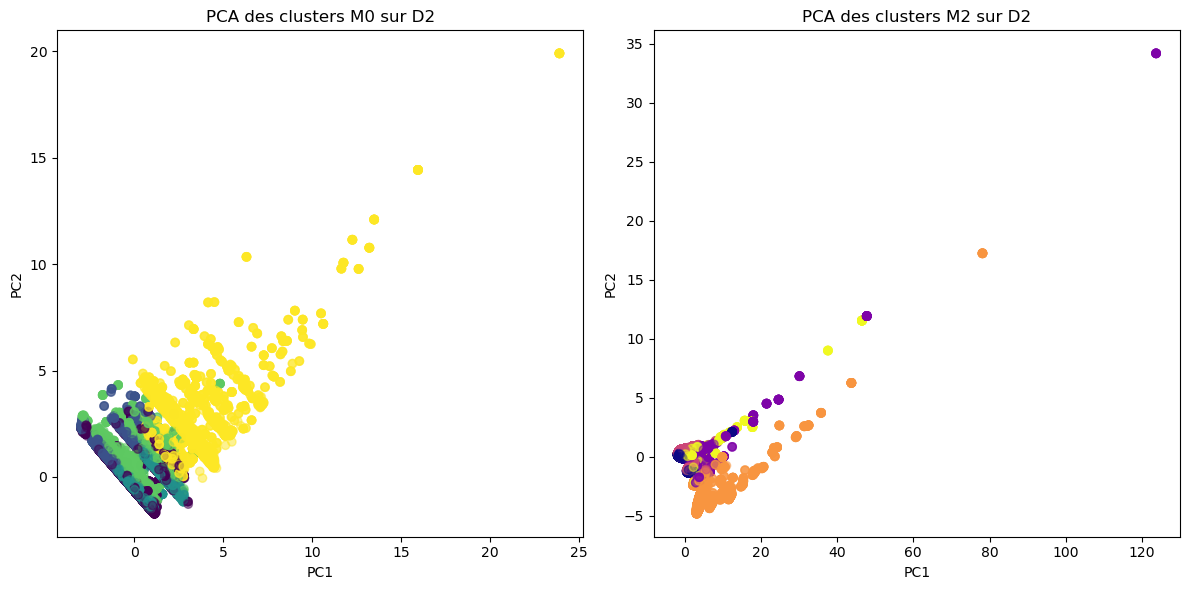

In [49]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D2_pca_M0 = pca.fit_transform(X_D2_transformed_M0)
X_D2_pca_M2 = pca.fit_transform(X_D2_transformed_M2)

# Scatterplot des clusters M0 sur D2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D2_pca_M0[:, 0],
    X_D2_pca_M0[:, 1],
    c=df_D2["Cluster_M0"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M0 sur D2")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M2 sur D2
plt.subplot(1, 2, 2)
plt.scatter(
    X_D2_pca_M2[:, 0],
    X_D2_pca_M2[:, 1],
    c=df_D2["Cluster_M2"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M2 sur D2")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [50]:
cluster_means_M1D2 = (
    df_D2.groupby("Cluster_M1")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M1D2)

               recency  frequency      monetary  avg_review  has_review  \
Cluster_M1                                                                
0           339.122168   1.035959    375.194455    1.769247    1.000000   
1           376.533620   1.049657    594.962350    4.152712    0.988001   
2           299.054646   2.221135    674.229498    4.122085    0.988943   
3           320.064327   1.333333  30971.504035    2.438596    0.883041   
4           350.965386   1.031528    215.828926    4.740423    0.988553   

            diversity_products  avg_installments  
Cluster_M1                                        
0                     1.017824          2.232111  
1                     1.017810          8.291871  
2                     2.128216          3.344359  
3                     1.058480          3.643275  
4                     1.000195          1.835028  


- Cluster 0: Clients insatisfaits
- Cluster 1: Clients avec le plus d'échelonnage
- Cluster 2: Clients achètent le plus fréquemment et une diversité de produits
- Cluster 3: Clients qui dépensent le plus
- Cluster 4: Clients les plus satisfaits

In [52]:
cluster_means_M0D2 = (
    df_D2.groupby("Cluster_M0")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M0D2)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M0                                                              
0           342.875617   1.034954  564.892125    1.303535    1.000000   
1           535.317959   1.034252  227.870218    4.588974    0.990584   
2           289.896974   1.032673  227.375612    4.572202    0.989357   
3           374.218294   1.054620  935.692763    4.107113    0.985503   
4           294.087254   2.226048  679.315888    4.089001    0.988879   

            diversity_products  avg_installments  
Cluster_M0                                        
0                     1.025018          2.451856  
1                     1.005663          2.044965  
2                     1.000000          1.980052  
3                     1.017116          8.841915  
4                     2.130026          3.423978  


- Cluster 0: clients insatisfaits
- Cluster 1: clients inactifs (très satisfaits)
- Cluster 2: clients nouveaux, le moins dépensiers et très satisfaits
- Cluster 3: clients le plus dépensiers et avec le plus d'échelonnage
- Cluster 4: clients achètent le plus fréquemment et le plus de types de produtis

In [54]:
cluster_means_M2D2 = (
    df_D2.groupby("Cluster_M2")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M2D2)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M2                                                              
0           265.146511   1.031513  211.729901    4.604430    0.988378   
1           362.816555   1.057096  905.163178    4.090702    0.986218   
2           497.367873   1.031468  226.064090    4.561268    0.991321   
3           295.049824   2.257024  655.560053    4.121415    0.988586   
4           331.101262   1.037777  581.590076    1.396028    1.000000   

            diversity_products  avg_installments  
Cluster_M2                                        
0                     1.000000          1.866333  
1                     1.021144          8.652207  
2                     1.004718          2.053768  
3                     2.134109          3.339447  
4                     1.026253          2.387374  


- Cluster 0: Clients nouveaux très satisfaits
- Cluster 1: Clients les plus dépensiers avec les plus d'échelonnage
- Cluster 2: Clients inactifs 
- Cluster 3: Clients achètent le plus fréquemment avec une diversité de produits
- Cluster 4: Clients insatisfaits

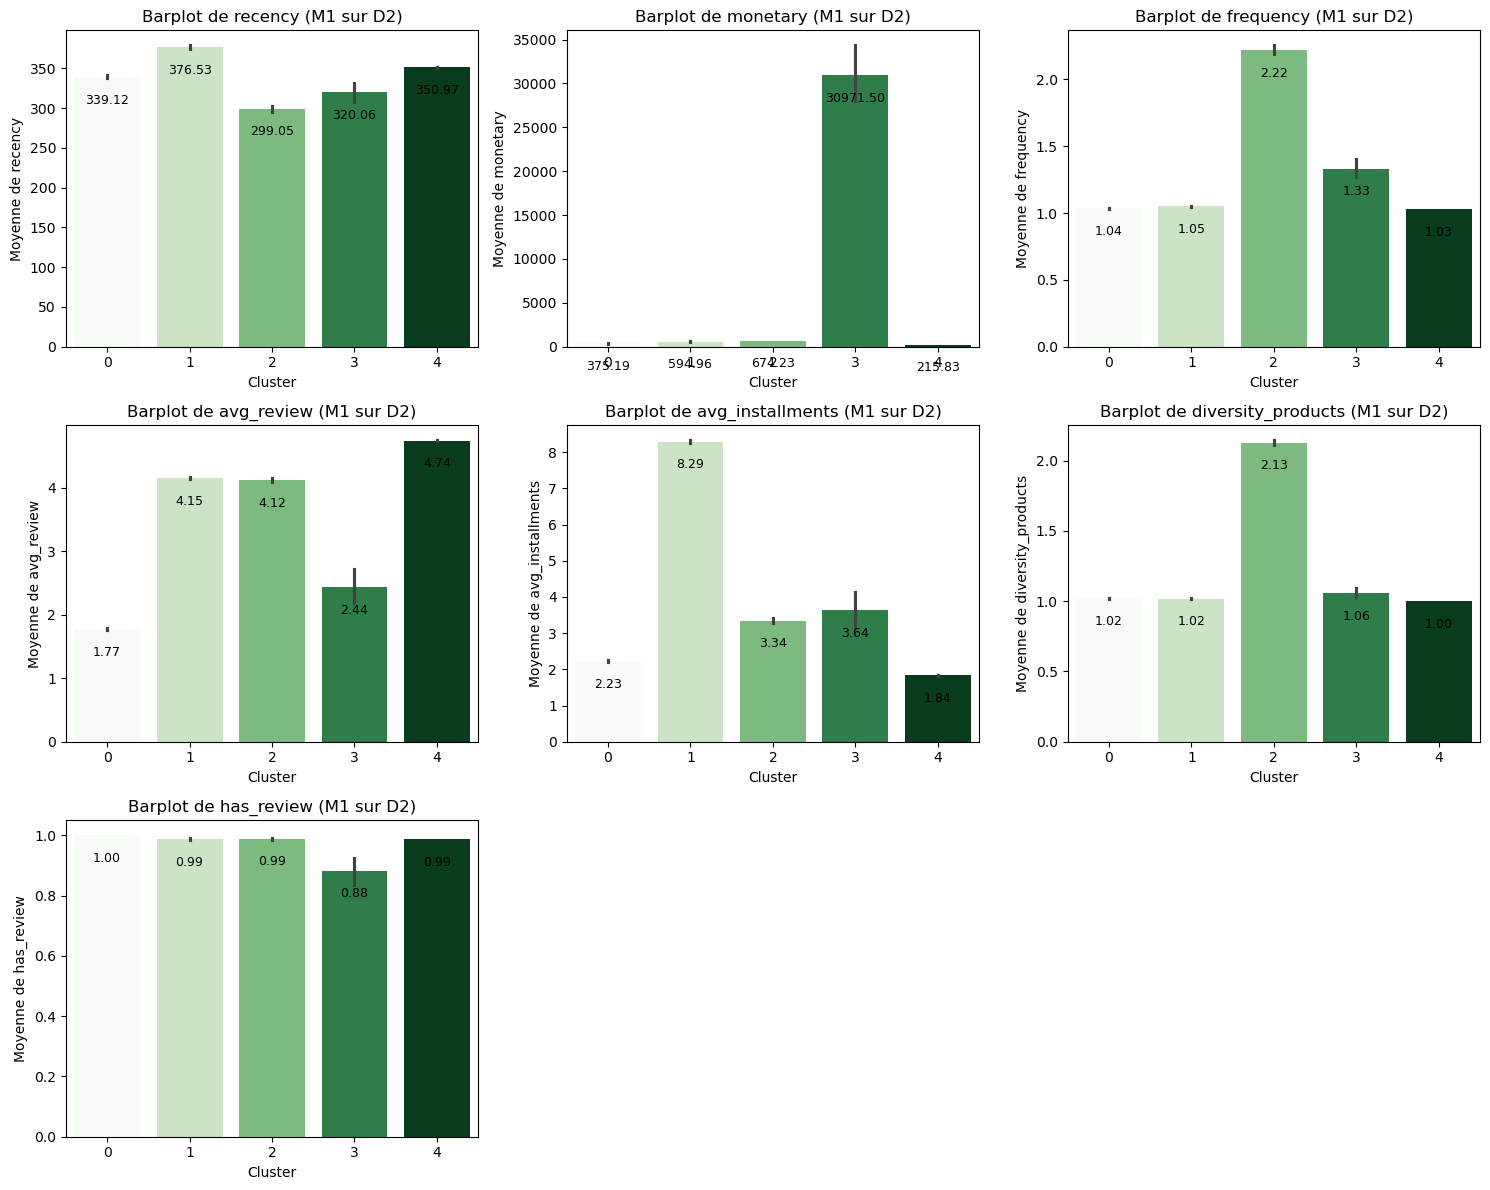

In [56]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M1 sur D2
    sns.barplot(
        data=df_D2,
        x="Cluster_M1",
        y=feature,
        hue="Cluster_M1",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M1 sur D2)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

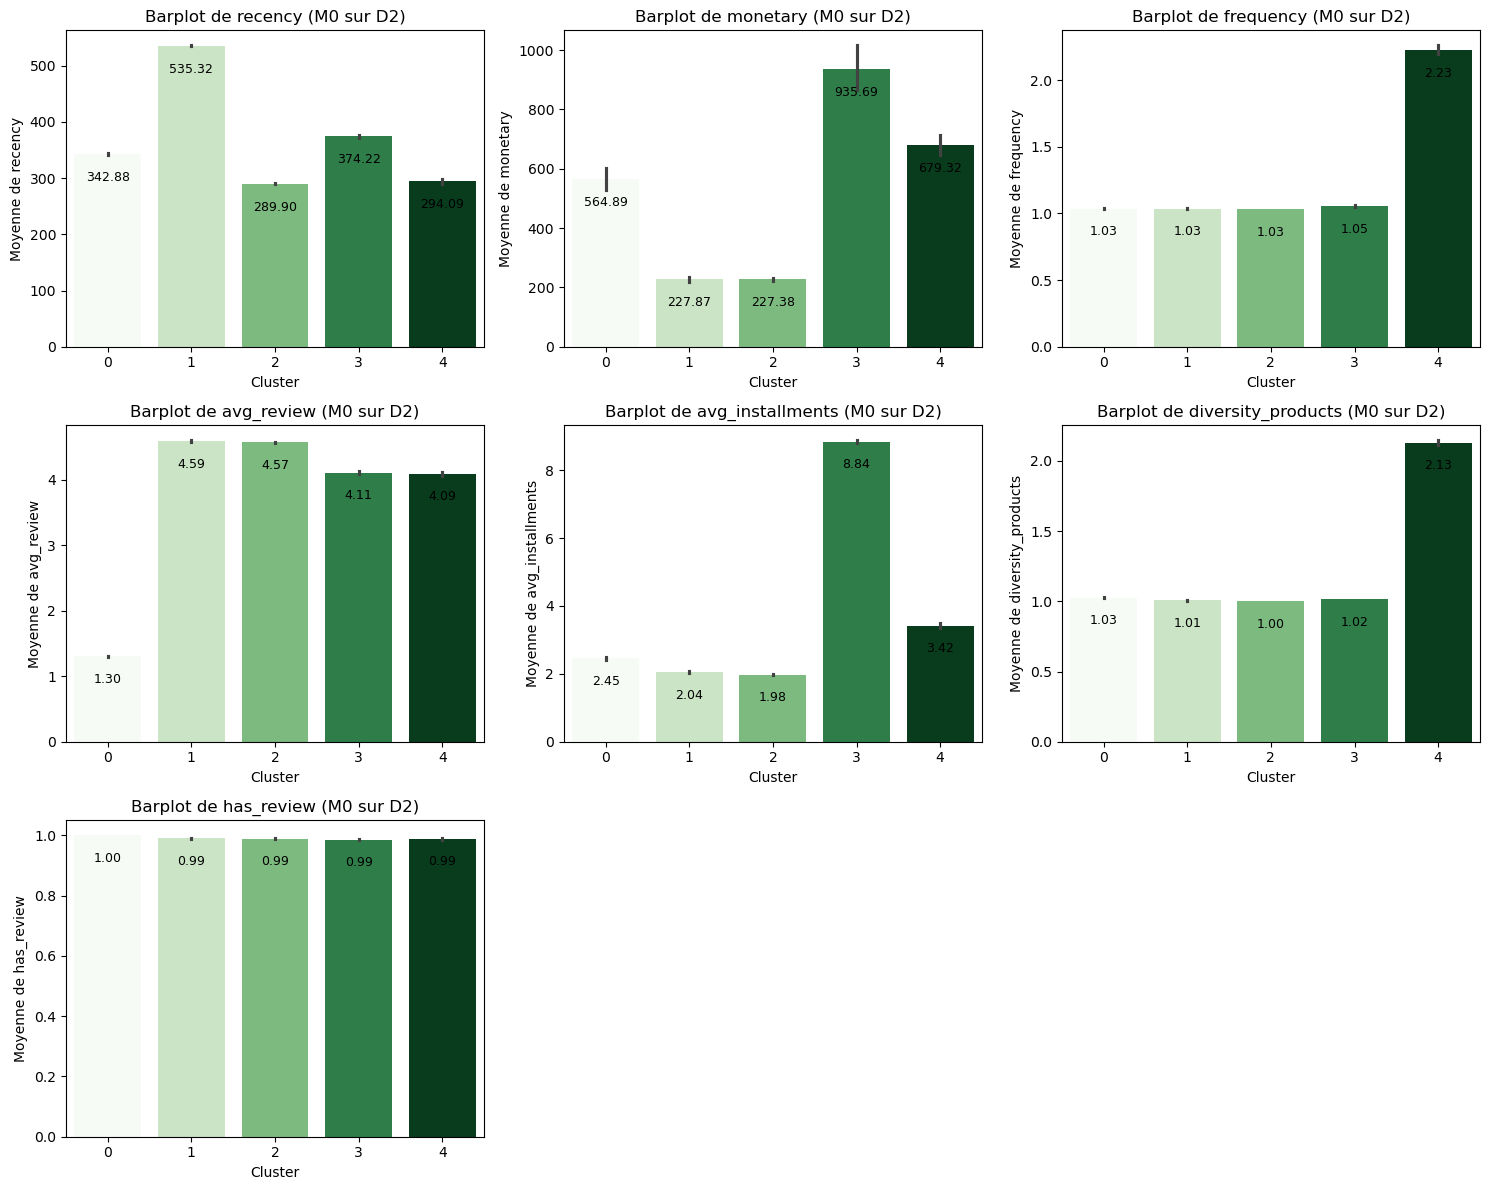

In [57]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M0 sur D2
    sns.barplot(
        data=df_D2,
        x="Cluster_M0",
        y=feature,
        hue="Cluster_M0",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M0 sur D2)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

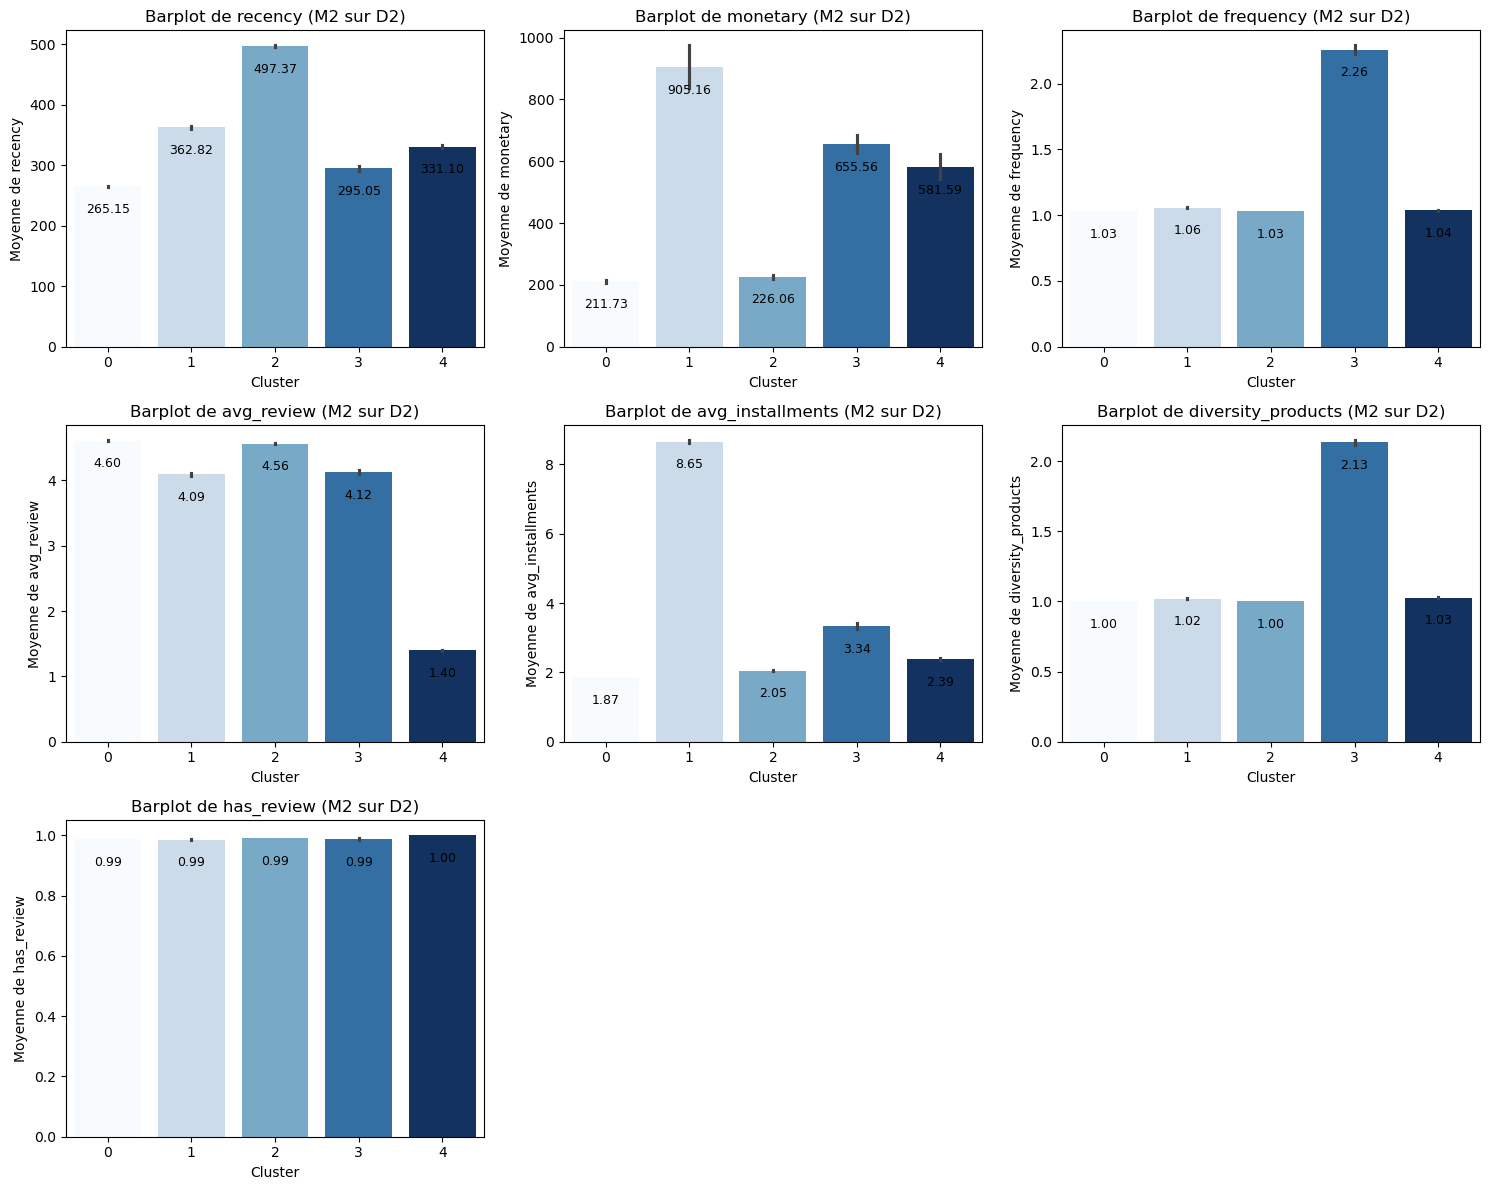

In [58]:
# M1 sur D1
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M2 sur D2
    sns.barplot(
        data=df_D2,
        x="Cluster_M2",
        y=feature,
        hue="Cluster_M2",
        palette="Blues",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M2 sur D2)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### d. ARI

Rappel: L'Adjusted Rand Index (ARI) est une métrique qui mesure la similarité entre deux partitions (deux attributions de clusters) en prenant en compte le hasard. Il varie entre -1 et 1 :

- ARI = 1 => Les deux partitions sont identiques (chaque client a été classé exactement dans le même cluster dans les deux périodes).
- ARI = 0 => La partition est aléatoire, pas meilleure que du hasard.
- ARI < 0 => Les clusters sont moins bien que du hasard, ce qui est rare en pratique

- Pour utiliser l'ARI il faut absolument faire la comparaison sur les clients communs aux deux périodes

In [61]:
# 3. Calcul de l'ARI entre M1 et M2 sur D2
ari_M1_M2 = adjusted_rand_score(df_D2["Cluster_M1"], df_D2["Cluster_M2"])
print(f"ARI entre M1 et M2 sur D2 : {ari_M1_M2:.4f}")

ARI entre M1 et M2 sur D2 : 0.5089


In [62]:
# 3. Calcul de l'ARI entre M0 et M2 sur D2
ari_M0_M2 = adjusted_rand_score(df_D2["Cluster_M0"], df_D2["Cluster_M2"])
print(f"ARI entre M0 et M2 sur D2 : {ari_M0_M2:.4f}")

ARI entre M0 et M2 sur D2 : 0.6874


### e. Test de Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov permet de comparer si deux distributions sont significativement différentes.

- p-value > 0.05 : On ne rejette pas l’hypothèse que les distributions sont similaires (pas de changement significatif).
- p-value < 0.05 : On rejette l’hypothèse de similarité, donc la distribution a changé entre les périodes.

Ici , permet de voir si les distributions des variables au sein des clusters ont changé entre M0D1 et M1D1. Est-ce que chaque cluster contient encore les mêmes types d'observations ? Ou bien les clusters ont-ils changé de nature, en regroupant des profils différents ?
Si les distributions sont similaires = les clusters ont juste été renommés ou réorganisés.
Si elles sont différentes = la nature des clusters a changé, donc l’algorithme a trouvé de nouvelles structures dans les données.


In [65]:
ks_results = {}

print("\nComparaison des distributions entre M1D2 et M2D2 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D2_M1 = df_D2[df_D2["Cluster_M1"] == cluster]
    df_D2_M2 = df_D2[df_D2["Cluster_M2"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D2_M1[feature], df_D2_M2[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M1D2 et M2D2."
            )
        else:
            print("Aucune différence significative entre M1D2 et M2D2.")
        print("-" * 50)


Comparaison des distributions entre M1D2 et M2D2 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.3071
  -> p-value: 0.0000
La distribution est significativement différente entre M1D2 et M2D2.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.1259
  -> p-value: 0.0000
La distribution est significativement différente entre M1D2 et M2D2.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0040
  -> p-value: 0.9888
Aucune différence significative entre M1D2 et M2D2.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.9237
  -> p-value: 0.0000
La distribution est significativement différente entre M1D2 et M2D2.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0716
  -> p-value: 0.0000
La distribution est significativement différente entre M1D2 et M2D2.
-------------------------------------------------

In [66]:
ks_results = {}

print("\nComparaison des distributions entre M0D2 et M2D2 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D2_M0 = df_D2[df_D2["Cluster_M0"] == cluster]
    df_D2_M2 = df_D2[df_D2["Cluster_M2"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D2_M0[feature], df_D2_M2[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M0D2 et M2D2."
            )
        else:
            print("Aucune différence significative entre M0D2 et M2D2.")
        print("-" * 50)


Comparaison des distributions entre M0D2 et M2D2 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.3342
  -> p-value: 0.0000
La distribution est significativement différente entre M0D2 et M2D2.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.1668
  -> p-value: 0.0000
La distribution est significativement différente entre M0D2 et M2D2.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0032
  -> p-value: 1.0000
Aucune différence significative entre M0D2 et M2D2.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.9473
  -> p-value: 0.0000
La distribution est significativement différente entre M0D2 et M2D2.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.1076
  -> p-value: 0.0000
La distribution est significativement différente entre M0D2 et M2D2.
-------------------------------------------------

Les features qui ont des distributions significativement différentes entre M0D2 et M2D2 (p-value < 0.05) :

- recency : Différence significative dans tous les clusters
- monetary : Différence significative dans tous les clusters
- avg_review : Différence significative dans tous les clusters sauf le Cluster 2
- avg_installments : Différence significative dans tous les clusters
- diversity_products : Différence significative dans tous les clusters sauf 1 et 2



Les features qui n’ont PAS de différence significative (p-value > 0.05) :

- frequency : Pas de différence significative dans Clusters 0, 2
- has_review : Pas de différence significative dans Clusters 0, 1, 2, 3, 4


Clusters avec les différences les plus marquées :

- Cluster 1 et Cluster 4 montrent les plus grandes différences entre M0D2 et M2D2 sur plusieurs features.
- Cluster 2 présente moins de différences, surtout sur avg_review, frequency, et has_review.

## Période 3: 04/09/2016 au 30/06/2018

### a. Sélection de la période

In [70]:
# Sélectionner la période 3
mask_D3 = (df_final["order_purchase_timestamp"] >= "2016-09-04") & (
    df_final["order_purchase_timestamp"] <= "2018-06-30"
)
df_D3 = df_final[mask_D3].copy()
df_D3_features = df_D3[features]

# Vérification
print("Shape des données D2 :", df_D3.shape)

Shape des données D2 : (104223, 13)


### b. Lancement du modèle

In [72]:
# 1. Application de M0 sur D3 (seulement transformation)

# Appliquer la transformation de M0 sur D3
X_D3_transformed_M0 = pipeline.named_steps["preprocessor"].transform(df_D3_features)
# Vérification
print("Shape de X_D3_transformed_M0 :", X_D3_transformed_M0.shape)

# Prédiction des clusters avec M0
clusters_D3_M0 = pipeline.named_steps["kmeans"].predict(X_D3_transformed_M0)
df_D3["Cluster_M0"] = clusters_D3_M0

# Vérification
print("Distribution des clusters M0 sur D3 :")
print(df_D3["Cluster_M0"].value_counts().sort_index())

Shape de X_D3_transformed_M0 : (104223, 7)
Distribution des clusters M0 sur D3 :
Cluster_M0
0    15936
1    14656
2    55939
3    12163
4     5529
Name: count, dtype: int64


In [73]:
# 1. Application de M2 sur D3 (seulement transformation)

# Appliquer la transformation de M2 sur D3
X_D3_transformed_M2 = pipeline_M2.named_steps["preprocessor"].transform(df_D3_features)
# Vérification
print("Shape de X_D3_transformed_M2 :", X_D3_transformed_M2.shape)

# Prédiction des clusters avec M2
clusters_D3_M2 = pipeline_M2.named_steps["kmeans"].predict(X_D3_transformed_M2)
df_D3["Cluster_M2"] = clusters_D3_M2

# Vérification
print("Distribution des clusters M2 sur D3 :")
print(df_D3["Cluster_M2"].value_counts().sort_index())

Shape de X_D3_transformed_M2 : (104223, 7)
Distribution des clusters M2 sur D3 :
Cluster_M2
0    46559
1    13375
2    22467
3     5312
4    16510
Name: count, dtype: int64


In [74]:
# 2. Création et fit du nouveau modèle M3 sur D3
# Construction et entraînement du pipeline M3 avec la fonction build_pipeline
# Fit de la pipeline M3 sur D3
pipeline_M3 = build_pipeline()
X_D3_transformed_M3 = pipeline_M3.fit_transform(df_D3_features)
clusters_D3_M3 = pipeline_M3.named_steps["kmeans"].labels_
df_D3["Cluster_M3"] = clusters_D3_M3

# Vérification
print("Distribution des clusters M3 sur D3 :")
print(df_D3["Cluster_M3"].value_counts().sort_index())

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
Distribution des clusters M3 sur D3 :
Cluster_M3
0    47806
1      228
2    19464
3     5633
4    31092
Name: count, dtype: int64


### c. Visualisations

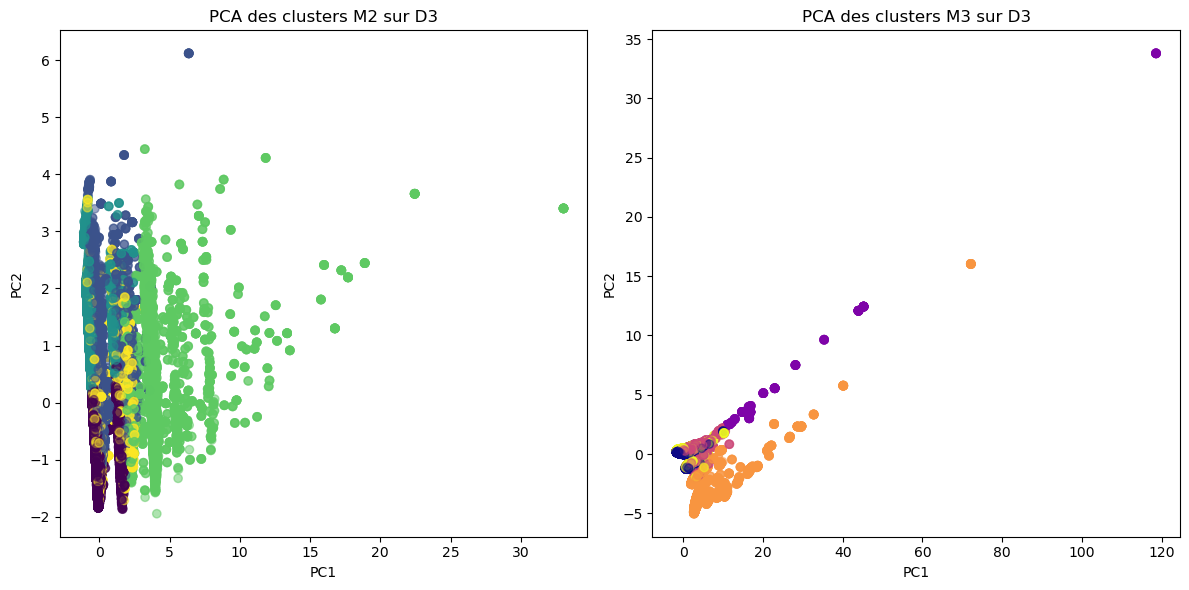

In [76]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D3_pca_M2 = pca.fit_transform(X_D3_transformed_M2)
X_D3_pca_M3 = pca.fit_transform(X_D3_transformed_M3)

# Scatterplot des clusters M2 sur D3
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D3_pca_M2[:, 0],
    X_D3_pca_M2[:, 1],
    c=df_D3["Cluster_M2"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M2 sur D3")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M3 sur D3
plt.subplot(1, 2, 2)
plt.scatter(
    X_D3_pca_M3[:, 0],
    X_D3_pca_M3[:, 1],
    c=df_D3["Cluster_M3"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M3 sur D3")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

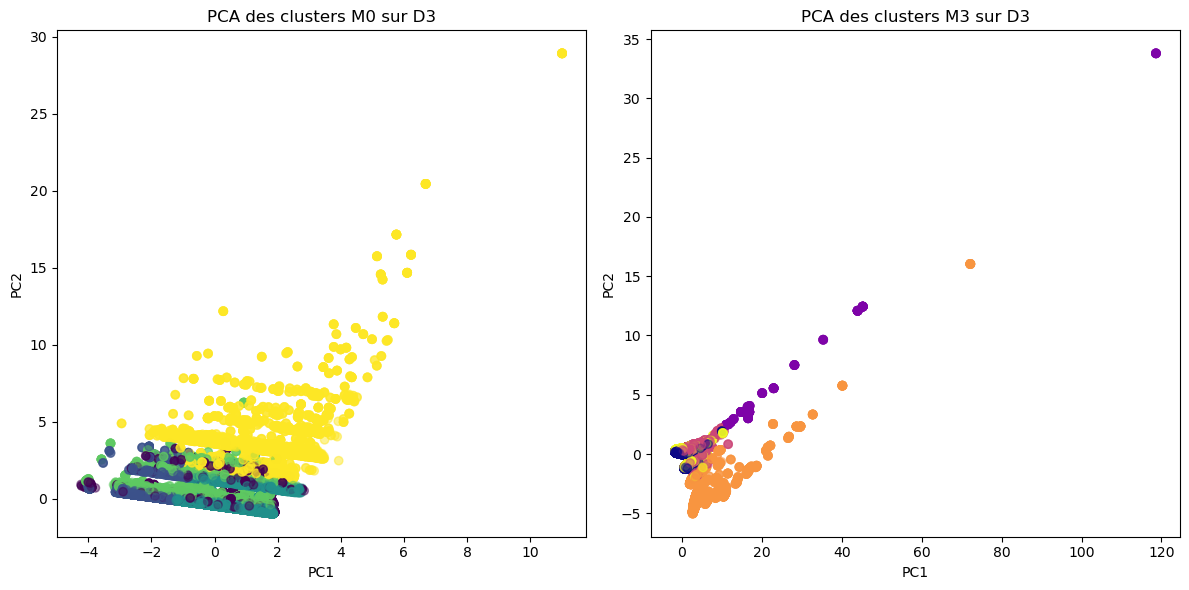

In [77]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D3_pca_M0 = pca.fit_transform(X_D3_transformed_M0)
X_D3_pca_M3 = pca.fit_transform(X_D3_transformed_M3)

# Scatterplot des clusters M0 sur D3
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D3_pca_M0[:, 0],
    X_D3_pca_M0[:, 1],
    c=df_D3["Cluster_M0"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M0 sur D3")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M3 sur D3
plt.subplot(1, 2, 2)
plt.scatter(
    X_D3_pca_M3[:, 0],
    X_D3_pca_M3[:, 1],
    c=df_D3["Cluster_M3"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M3 sur D3")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [78]:
cluster_means_M2D3 = (
    df_D3.groupby("Cluster_M2")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M2D3)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M2                                                              
0           234.430894   1.028867  217.553138    4.604539    0.989583   
1           334.728897   1.052336  893.109915    4.116131    0.986991   
2           497.367873   1.031468  226.064090    4.561268    0.991321   
3           271.881589   2.225339  649.754970    4.143238    0.989834   
4           309.834706   1.034888  584.362604    1.375298    1.000000   

            diversity_products  avg_installments  
Cluster_M2                                        
0                     1.000000          1.908628  
1                     1.021084          8.676639  
2                     1.004718          2.053768  
3                     2.129706          3.309223  
4                     1.027922          2.426762  


- Cluster 0: Nouveaux clients très satisfaits
- Cluster 1: Clients avec dépenses élevées avec beaucoup d'échelonange
- Cluster 2: Clients inactifs 
- Cluster 3: Clients achetant fréquemment avec une diversité de produits
- Cluster 4: Clients insatisfaits

In [80]:
cluster_means_M0D3 = (
    df_D3.groupby("Cluster_M0")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M0D3)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M0                                                              
0           320.801456   1.032129  569.842247    1.291803    1.000000   
1           535.317959   1.034252  227.870218    4.588974    0.990584   
2           258.689876   1.030390  229.673224    4.577052    0.990204   
3           345.982899   1.049905  925.234812    4.131978    0.986188   
4           269.285947   2.178332  674.754041    4.068345    0.990233   

            diversity_products  avg_installments  
Cluster_M0                                        
0                     1.023155          2.481478  
1                     1.005663          2.044965  
2                     1.000000          2.007746  
3                     1.015046          8.868581  
4                     2.124073          3.437257  


- Cluster 0: clients insatisfaits
- Cluster 1: clients inactifs (très satisfaits)
- Cluster 2: clients nouveaux, le moins dépensiers et très satisfaits
- Cluster 3: clients le plus dépensiers et avec le plus d'échelonnage
- Cluster 4: clients achètent le plus fréquemment et le plus de types de produtis

In [82]:
cluster_means_M3D3 = (
    df_D3.groupby("Cluster_M3")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M3D3)

               recency  frequency      monetary  avg_review  has_review  \
Cluster_M3                                                                
0           224.585721   1.029599    246.116413    4.626552    0.989102   
1           298.403509   1.250000  27111.558947    2.289474    0.912281   
2           311.858148   1.037197    480.588660    1.473909    1.000000   
3           277.769040   2.167229    688.414978    4.124779    0.990414   
4           472.358677   1.034253    291.824670    4.599479    0.989933   

            diversity_products  avg_installments  
Cluster_M3                                        
0                     1.000000          2.426283  
1                     1.043860          4.583333  
2                     1.025894          3.324488  
3                     2.116457          3.499662  
4                     1.001512          3.449215  


- Cluster 0: Clients nouveaux très satisfaits
- Cluster 1: Clients les plus dépensiers avec les plus d'échelonnage
- Cluster 2: Clients insatisfaits
- Cluster 3: Clients achètent le plus fréquemment avec une diversité de produits
- Cluster 4: Clients inactifs

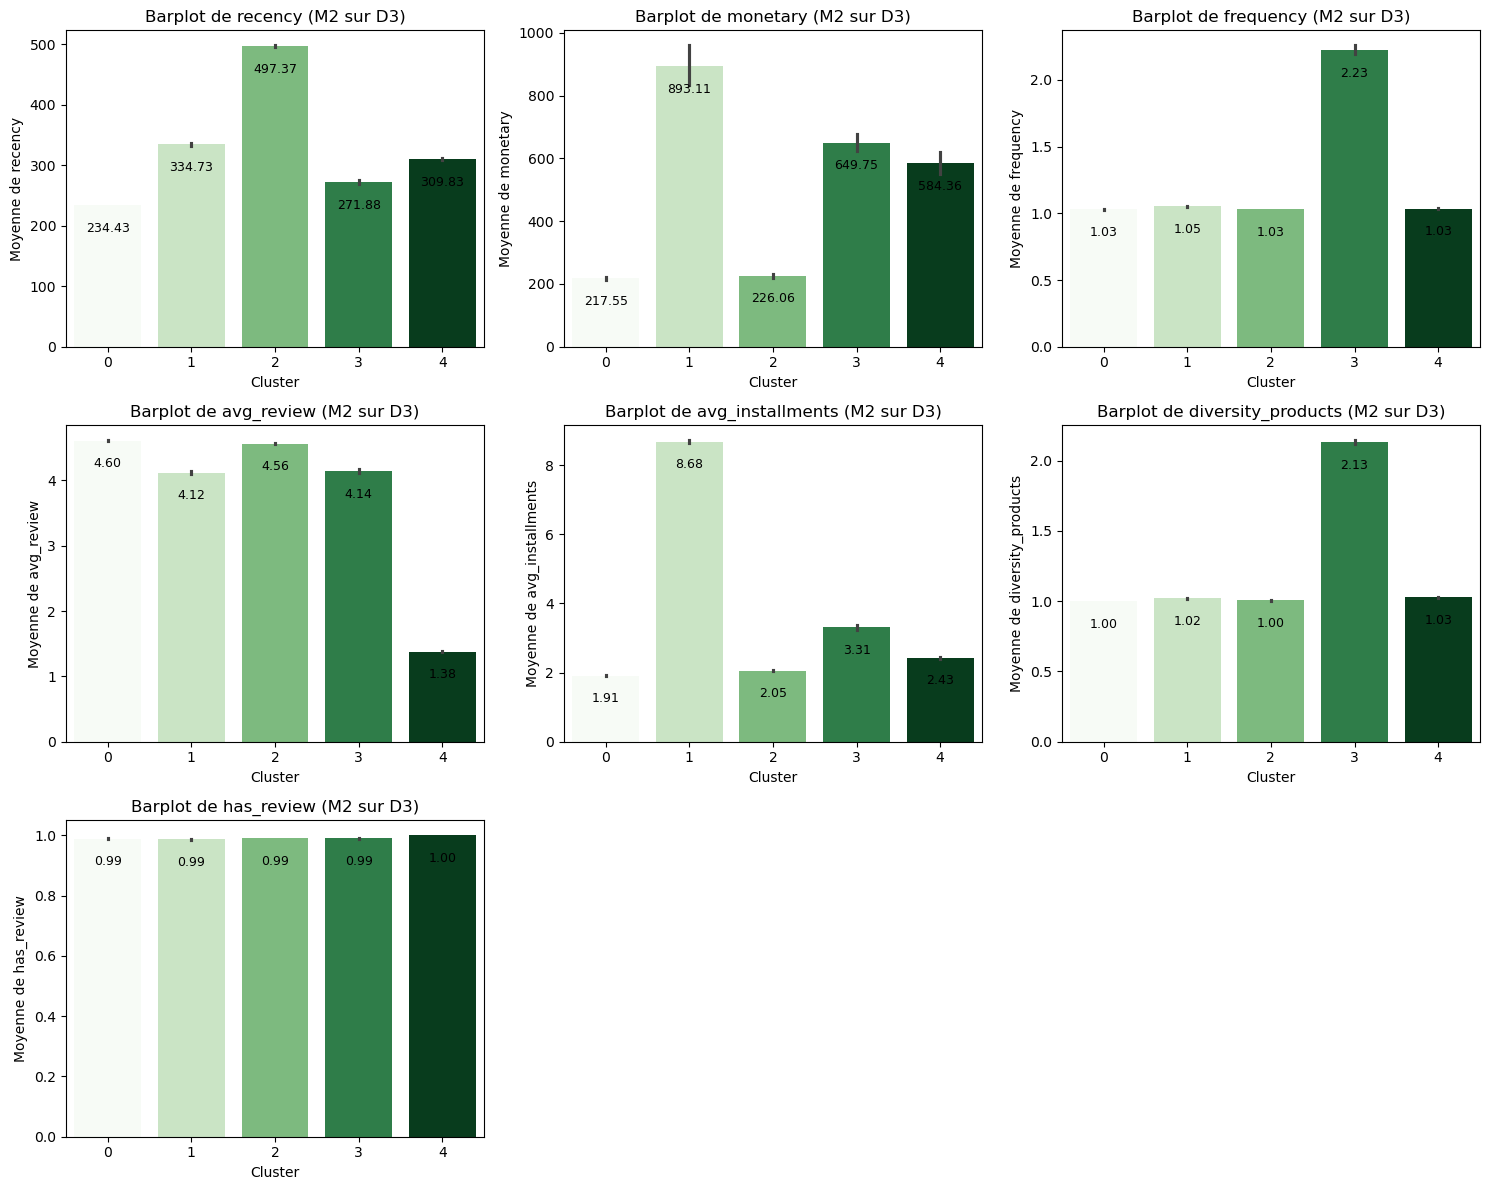

In [84]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M2 sur D3
    sns.barplot(
        data=df_D3,
        x="Cluster_M2",
        y=feature,
        hue="Cluster_M2",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M2 sur D3)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

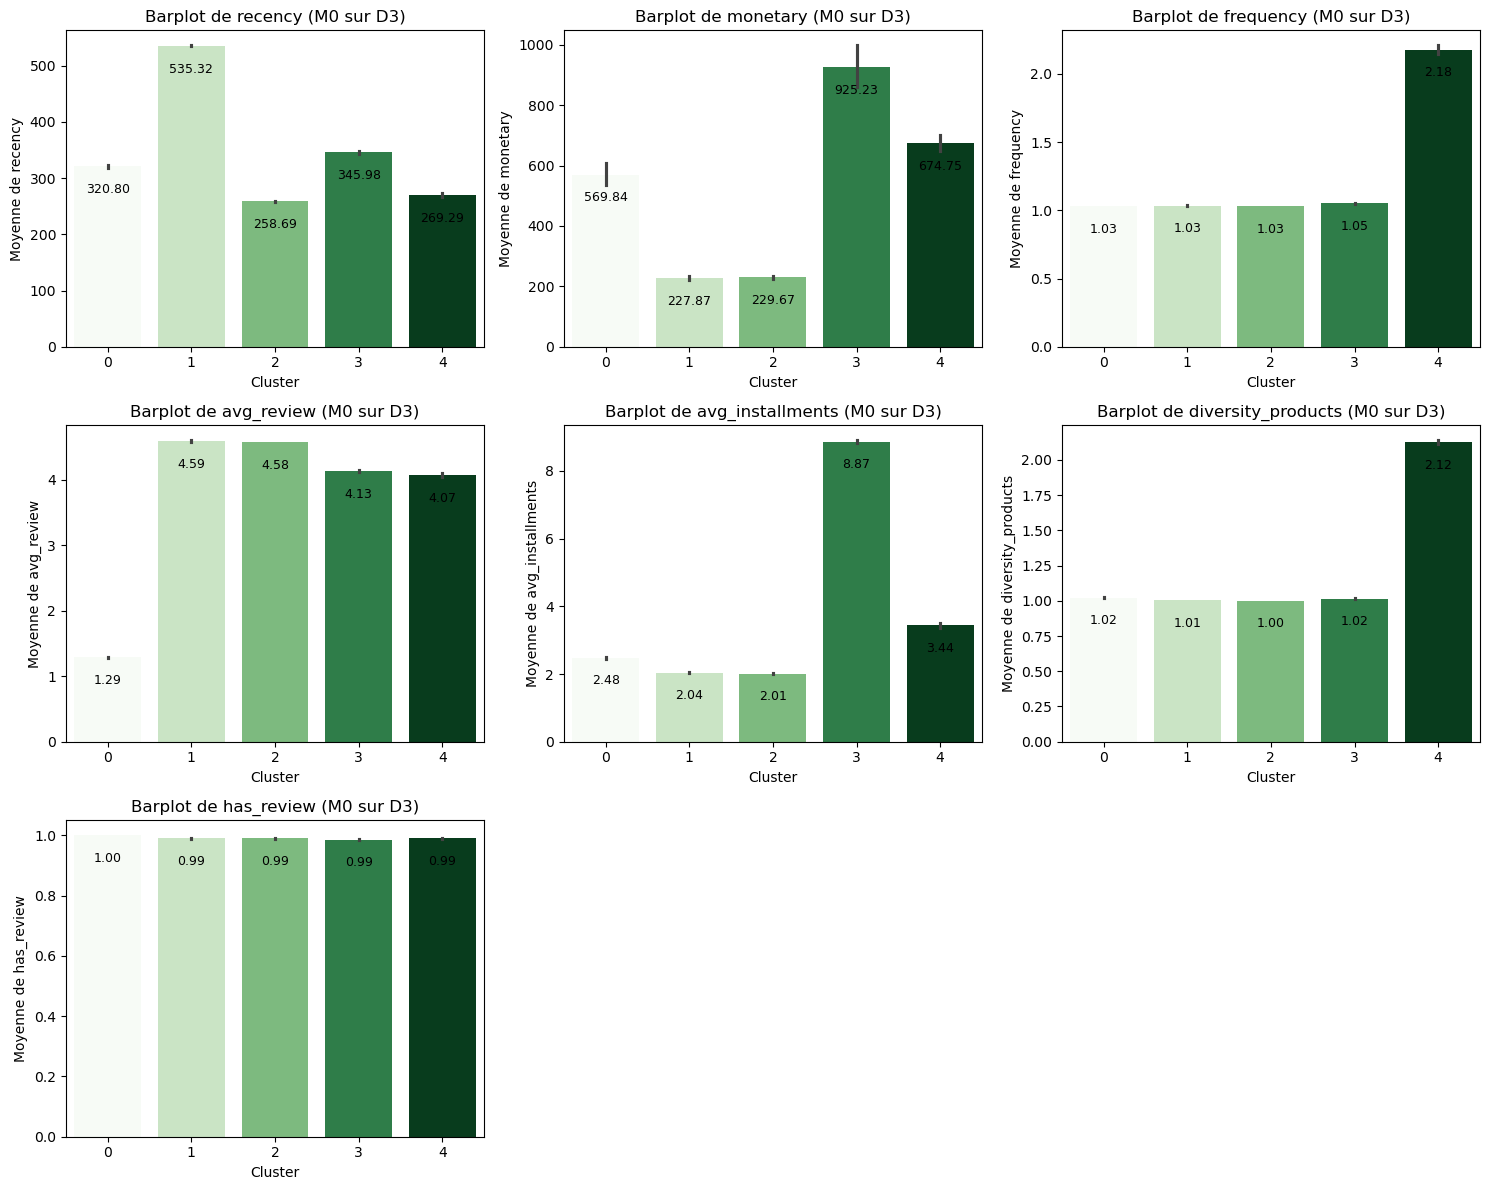

In [85]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M0 sur D3
    sns.barplot(
        data=df_D3,
        x="Cluster_M0",
        y=feature,
        hue="Cluster_M0",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M0 sur D3)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

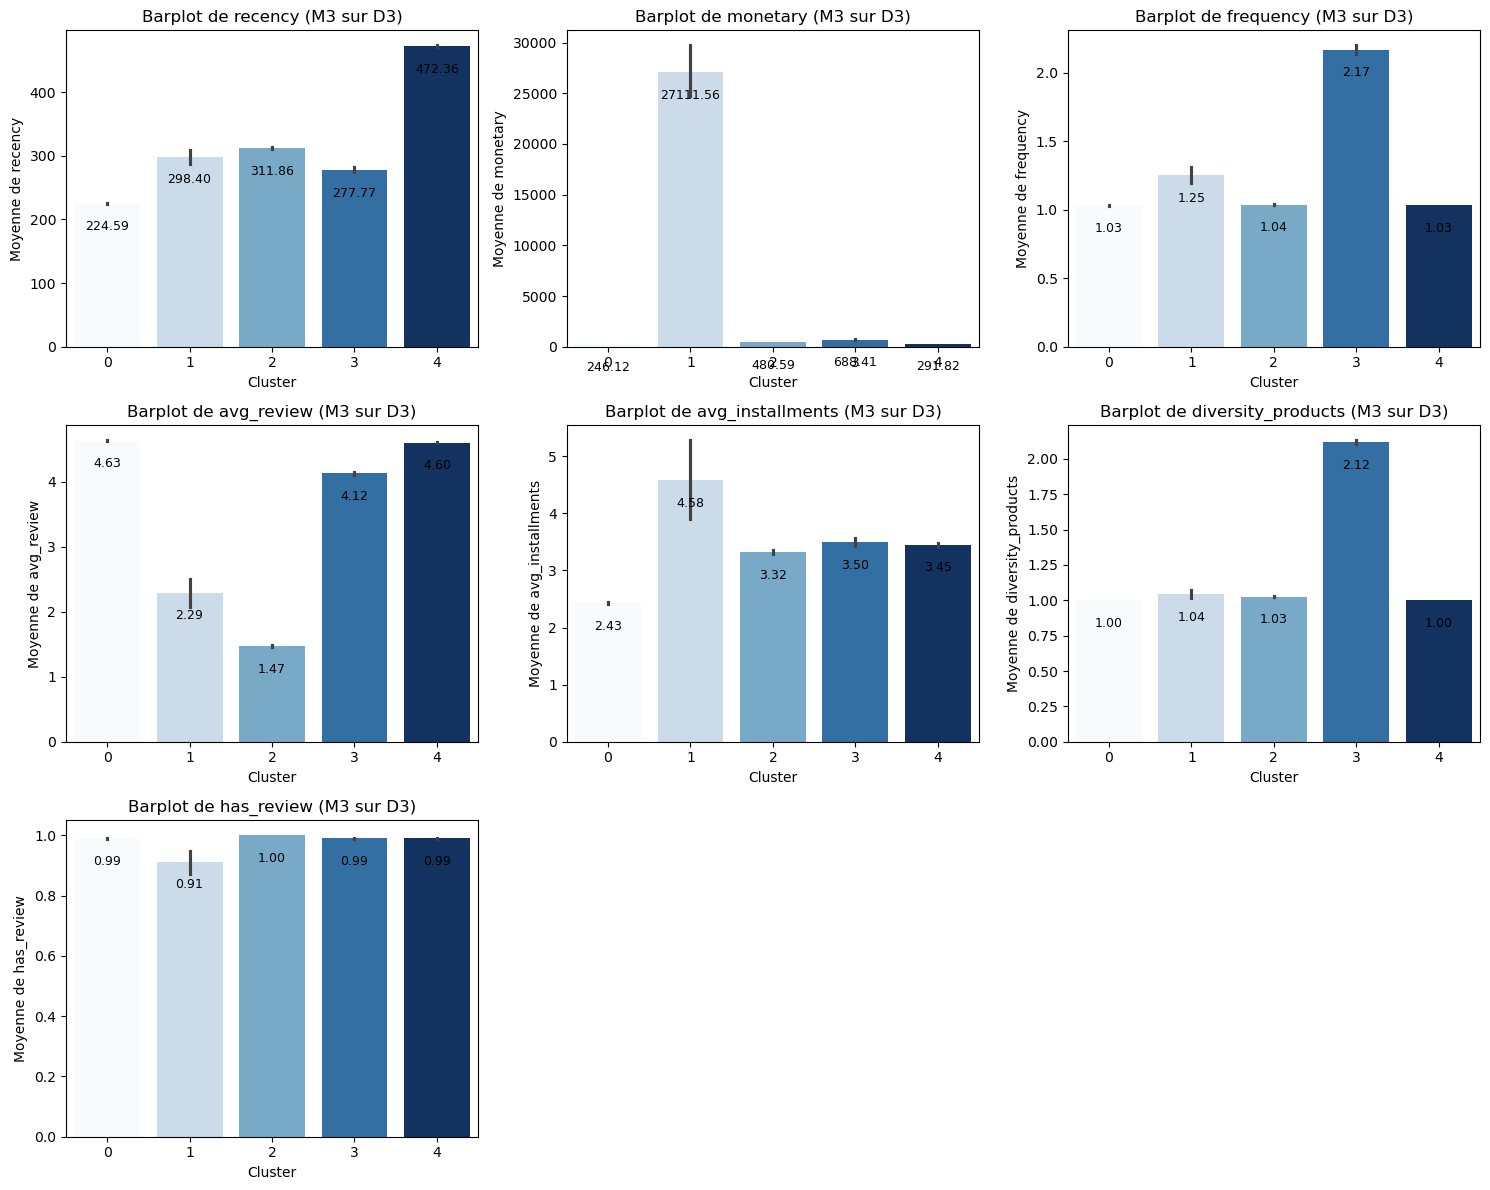

In [86]:
# M3 sur D3
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M3 sur D3
    sns.barplot(
        data=df_D3,
        x="Cluster_M3",
        y=feature,
        hue="Cluster_M3",
        palette="Blues",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M3 sur D3)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### d. ARI

Rappel: L'Adjusted Rand Index (ARI) est une métrique qui mesure la similarité entre deux partitions (deux attributions de clusters) en prenant en compte le hasard. Il varie entre -1 et 1 :

- ARI = 1 => Les deux partitions sont identiques (chaque client a été classé exactement dans le même cluster dans les deux périodes).
- ARI = 0 => La partition est aléatoire, pas meilleure que du hasard.
- ARI < 0 => Les clusters sont moins bien que du hasard, ce qui est rare en pratique

- Pour utiliser l'ARI il faut absolument faire la comparaison sur les clients communs aux deux périodes

In [89]:
# --- 3. Calcul de l'ARI entre M2 et M3 sur D3 ---
ari_M2_M3 = adjusted_rand_score(df_D3["Cluster_M2"], df_D3["Cluster_M3"])
print(f"ARI entre M2 et M3 sur D3 : {ari_M2_M3:.4f}")

ARI entre M2 et M3 sur D3 : 0.7259


In [90]:
# --- 3. Calcul de l'ARI entre M0 et M3 sur D3 ---
ari_M0_M3 = adjusted_rand_score(df_D3["Cluster_M0"], df_D3["Cluster_M3"])
print(f"ARI entre M0 et M3 sur D3 : {ari_M0_M3:.4f}")

ARI entre M0 et M3 sur D3 : 0.5426


### e. Test de Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov permet de comparer si deux distributions sont significativement différentes.

- p-value > 0.05 : On ne rejette pas l’hypothèse que les distributions sont similaires (pas de changement significatif).
- p-value < 0.05 : On rejette l’hypothèse de similarité, donc la distribution a changé entre les périodes.

Ici , permet de voir si les distributions des variables au sein des clusters ont changé entre M0D1 et M1D1. Est-ce que chaque cluster contient encore les mêmes types d'observations ? Ou bien les clusters ont-ils changé de nature, en regroupant des profils différents ?
Si les distributions sont similaires = les clusters ont juste été renommés ou réorganisés.
Si elles sont différentes = la nature des clusters a changé, donc l’algorithme a trouvé de nouvelles structures dans les données.


In [93]:
ks_results = {}

print("\nComparaison des distributions entre M2D3 et M3D3 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D3_M2 = df_D3[df_D3["Cluster_M2"] == cluster]
    df_D3_M3 = df_D3[df_D3["Cluster_M3"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D3_M2[feature], df_D3_M3[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M2D3 et M3D3."
            )
        else:
            print("Aucune différence significative entre M2D3 et M3D3.")
        print("-" * 50)


Comparaison des distributions entre M2D3 et M3D3 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.0587
  -> p-value: 0.0000
La distribution est significativement différente entre M2D3 et M3D3.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.0338
  -> p-value: 0.0000
La distribution est significativement différente entre M2D3 et M3D3.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0007
  -> p-value: 1.0000
Aucune différence significative entre M2D3 et M3D3.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.0122
  -> p-value: 0.0017
La distribution est significativement différente entre M2D3 et M3D3.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0854
  -> p-value: 0.0000
La distribution est significativement différente entre M2D3 et M3D3.
-------------------------------------------------

In [94]:
ks_results = {}

print("\nComparaison des distributions entre M0D3 et M3D3 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D3_M0 = df_D3[df_D3["Cluster_M0"] == cluster]
    df_D3_M3 = df_D3[df_D3["Cluster_M3"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D3_M0[feature], df_D3_M3[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M0D3 et M3D3."
            )
        else:
            print("Aucune différence significative entre M0D3 et M3D3.")
        print("-" * 50)


Comparaison des distributions entre M0D3 et M3D3 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.3283
  -> p-value: 0.0000
La distribution est significativement différente entre M0D3 et M3D3.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.1372
  -> p-value: 0.0000
La distribution est significativement différente entre M0D3 et M3D3.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0023
  -> p-value: 1.0000
Aucune différence significative entre M0D3 et M3D3.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.9531
  -> p-value: 0.0000
La distribution est significativement différente entre M0D3 et M3D3.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0520
  -> p-value: 0.0000
La distribution est significativement différente entre M0D3 et M3D3.
-------------------------------------------------

1. Cluster 0 :
Différences significatives pour recency, monetary, avg_review, avg_installments, diversity_products.
Aucune différence pour frequency et has_review.
2. Cluster 1 :
Différences significatives pour recency, monetary, frequency, avg_review, avg_installments.
Aucune différence pour diversity_products et has_review.
3. Cluster 2 :
Différences significatives pour recency, monetary, avg_review, avg_installments, diversity_products.
Aucune différence pour frequency et has_review.
4. Cluster 3 :
Différences significatives pour recency, monetary, frequency, avg_review, avg_installments, diversity_products.
Aucune différence pour has_review.
5. Cluster 4 :
Différences significatives pour recency, monetary, frequency, avg_review, avg_installments, diversity_products.
Aucune différence pour has_review.


- Les features "recency" et "monetary" sont toujours significativement différentes entre M0D3 et M3D3 pour tous les clusters.
- "Avg_review" et "avg_installments" montrent souvent des différences sauf dans quelques cas isolés.
- "Diversity_products" est majoritairement différent, sauf dans le cluster 1.
- "Has_review" ne présente aucune différence significative dans tous les clusters.
- "Frequency" est parfois différent (clusters 1, 3 et 4) mais pas dans les clusters 0 et 2.

## Période du 04/09/2016 au 31/08/2018

### a. Sélection de la période

In [98]:
# Sélectionner la période 4
mask_D4 = (df_final["order_purchase_timestamp"] >= "2016-09-04") & (
    df_final["order_purchase_timestamp"] <= "2018-08-31"
)
df_D4 = df_final[mask_D4].copy()
df_D4_features = df_D4[features]

# Vérification
print("Shape des données D4 :", df_D4.shape)

Shape des données D4 : (119123, 13)


### b. Lancement du modèle

In [100]:
# 1. Application de M0 sur D4 (seulement transformation)

# Appliquer la transformation de M0 sur D4
X_D4_transformed_M0 = pipeline.named_steps["preprocessor"].transform(df_D4_features)
# Vérification
print("Shape de X_D4_transformed_M0 :", X_D4_transformed_M0.shape)

# Prédiction des clusters avec M0
clusters_D4_M0 = pipeline.named_steps["kmeans"].predict(X_D4_transformed_M0)
df_D4["Cluster_M0"] = clusters_D4_M0

# Vérification
print("Distribution des clusters M0 sur D4 :")
print(df_D4["Cluster_M0"].value_counts().sort_index())

Shape de X_D4_transformed_M0 : (119123, 7)
Distribution des clusters M0 sur D4 :
Cluster_M0
0    17155
1    14656
2    67918
3    13076
4     6318
Name: count, dtype: int64


In [101]:
# --- 1. Application de M3 sur D4 (seulement transformation) ---

# Appliquer la transformation de M3 sur D4
X_D4_transformed_M3 = pipeline_M3.named_steps["preprocessor"].transform(df_D4_features)
# Vérification
print("Shape de X_D4_transformed_M3 :", X_D4_transformed_M3.shape)

# Prédiction des clusters avec M3
clusters_D4_M3 = pipeline_M3.named_steps["kmeans"].predict(X_D4_transformed_M3)
df_D4["Cluster_M3"] = clusters_D4_M3

# Vérification
print("Distribution des clusters M3 sur D4 :")
print(df_D4["Cluster_M3"].value_counts().sort_index())

Shape de X_D4_transformed_M3 : (119123, 7)
Distribution des clusters M3 sur D4 :
Cluster_M3
0    60237
1      262
2    21217
3     6315
4    31092
Name: count, dtype: int64


In [102]:
# --- 2. Création et fit du nouveau modèle M4 sur D4 ---
# Construction et entraînement du pipeline M4
# Fit de la pipeline M4 sur D4
pipeline_M4 = build_pipeline()
X_D4_transformed_M4 = pipeline_M4.fit_transform(df_D4_features)
clusters_D4_M4 = pipeline_M4.named_steps["kmeans"].labels_
df_D4["Cluster_M4"] = clusters_D4_M4

# Vérification
print("Distribution des clusters M4 sur D4 :")
print(df_D4["Cluster_M4"].value_counts().sort_index())

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.2s
Distribution des clusters M4 sur D4 :
Cluster_M4
0    19603
1    32838
2    44896
3     6236
4    15550
Name: count, dtype: int64


### c. Visualisations

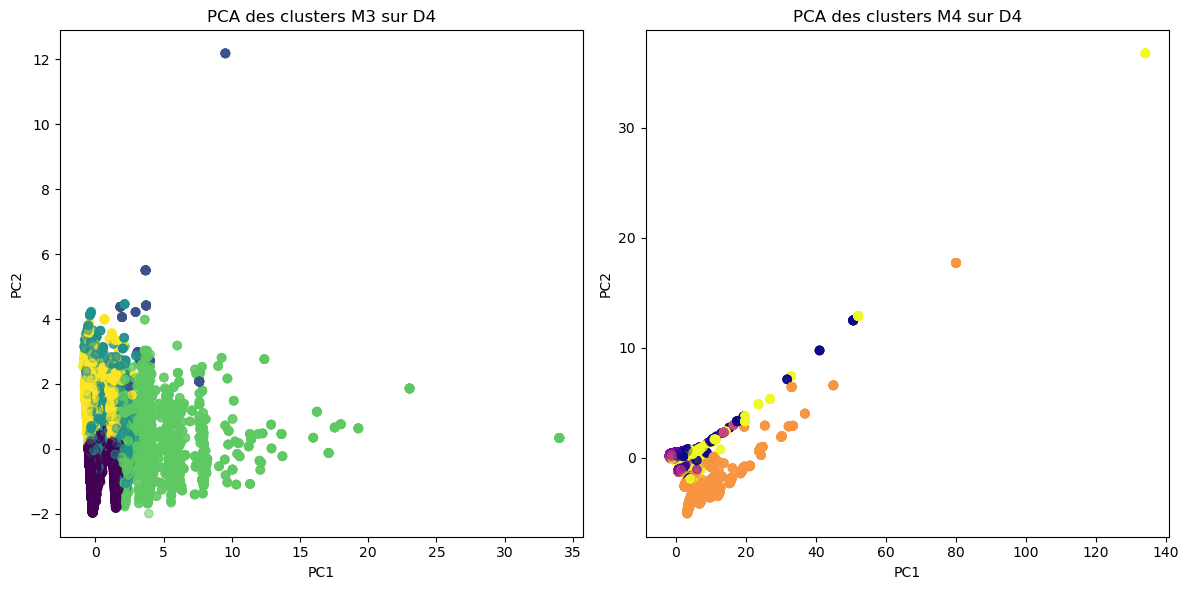

In [104]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D4_pca_M3 = pca.fit_transform(X_D4_transformed_M3)
X_D4_pca_M4 = pca.fit_transform(X_D4_transformed_M4)

# Scatterplot des clusters M3 sur D4
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D4_pca_M3[:, 0],
    X_D4_pca_M3[:, 1],
    c=df_D4["Cluster_M3"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M3 sur D4")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M4 sur D4
plt.subplot(1, 2, 2)
plt.scatter(
    X_D4_pca_M4[:, 0],
    X_D4_pca_M4[:, 1],
    c=df_D4["Cluster_M4"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M4 sur D4")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

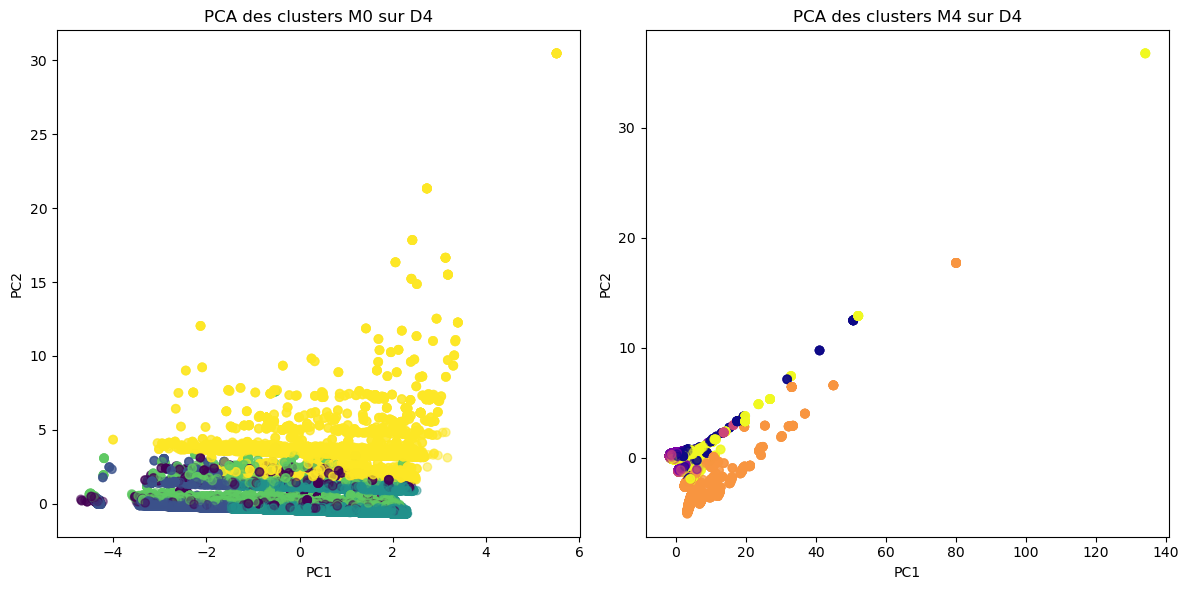

In [105]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D4_pca_M0 = pca.fit_transform(X_D4_transformed_M0)
X_D4_pca_M4 = pca.fit_transform(X_D4_transformed_M4)

# Scatterplot des clusters M0 sur D4
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D4_pca_M0[:, 0],
    X_D4_pca_M0[:, 1],
    c=df_D4["Cluster_M0"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M0 sur D4")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M4 sur D4
plt.subplot(1, 2, 2)
plt.scatter(
    X_D4_pca_M4[:, 0],
    X_D4_pca_M4[:, 1],
    c=df_D4["Cluster_M4"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M4 sur D4")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [106]:
cluster_means_M3D4 = (
    df_D4.groupby("Cluster_M3")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M3D4)

               recency  frequency      monetary  avg_review  has_review  \
Cluster_M3                                                                
0           194.228398   1.027657    247.530782    4.628534    0.989923   
1           269.847328   1.492366  26987.416489    2.488550    0.923664   
2           292.552623   1.035019    483.137471    1.457840    1.000000   
3           255.843230   2.145368    697.125886    4.112431    0.991132   
4           472.358677   1.034253    291.824670    4.599479    0.989933   

            diversity_products  avg_installments  
Cluster_M3                                        
0                     1.000000          2.480743  
1                     1.038168          4.576336  
2                     1.027808          3.317057  
3                     2.114173          3.506361  
4                     1.001512          3.449215  


- Cluster 0: nouveaux clients très satisfaits
- Cluster 1: Clients dépensant beaucoup avec un échelonnage de paiement élevé
- Cluster 2: CLients insatisfaits
- Cluster 3: Clients achetant fréquemment et une grande diversité de produits
- Cluster 4: Clients inactifs 

In [108]:
cluster_means_M0D4 = (
    df_D4.groupby("Cluster_M0")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M0D4)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M0                                                              
0           303.627572   1.030778  563.377349    1.273798    1.000000   
1           535.317959   1.034252  227.870218    4.588974    0.990584   
2           226.709885   1.028534  229.857831    4.576975    0.990709   
3           327.352631   1.047645  925.607125    4.129244    0.986923   
4           244.896328   2.146724  789.581814    4.021526    0.991136   

            diversity_products  avg_installments  
Cluster_M0                                        
0                     1.021510          2.487438  
1                     1.005663          2.044965  
2                     1.000000          2.049096  
3                     1.014225          8.919777  
4                     2.115068          3.473673  


- Cluster 0: clients insatisfaits
- Cluster 1: clients inactifs (très satisfaits)
- Cluster 2: clients nouveaux, le moins dépensiers et très satisfaits
- Cluster 3: clients le plus dépensiers et avec le plus d'échelonnage
- Cluster 4: clients achètent le plus fréquemment et le plus de types de produtis

In [110]:
cluster_means_M4D4 = (
    df_D4.groupby("Cluster_M4")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M4D4)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M4                                                              
0           290.674336   1.032036  531.023599    1.476101    1.000000   
1           446.037243   1.032219  221.242134    4.619861    0.990347   
2           171.367293   1.026662  214.825611    4.643777    0.990422   
3           255.281591   2.159237  804.111427    4.090763    0.991020   
4           298.974212   1.046559  860.041859    4.162637    0.987588   

            diversity_products  avg_installments  
Cluster_M4                                        
0                     1.021629          2.391573  
1                     1.000426          2.004324  
2                     1.000000          1.864253  
3                     2.117864          3.347926  
4                     1.017621          8.560772  


- Cluster 0: Clients instatisfaits
- Cluster 1: Clients inactifs
- Cluster 2: Clients nouveaux et très satisfaits
- Cluster 3: Clients achètent le plus fréquemment avec une diversité de produits
- Cluster 4: Clients dépendant le plus avec beaucoup d'échelonnage

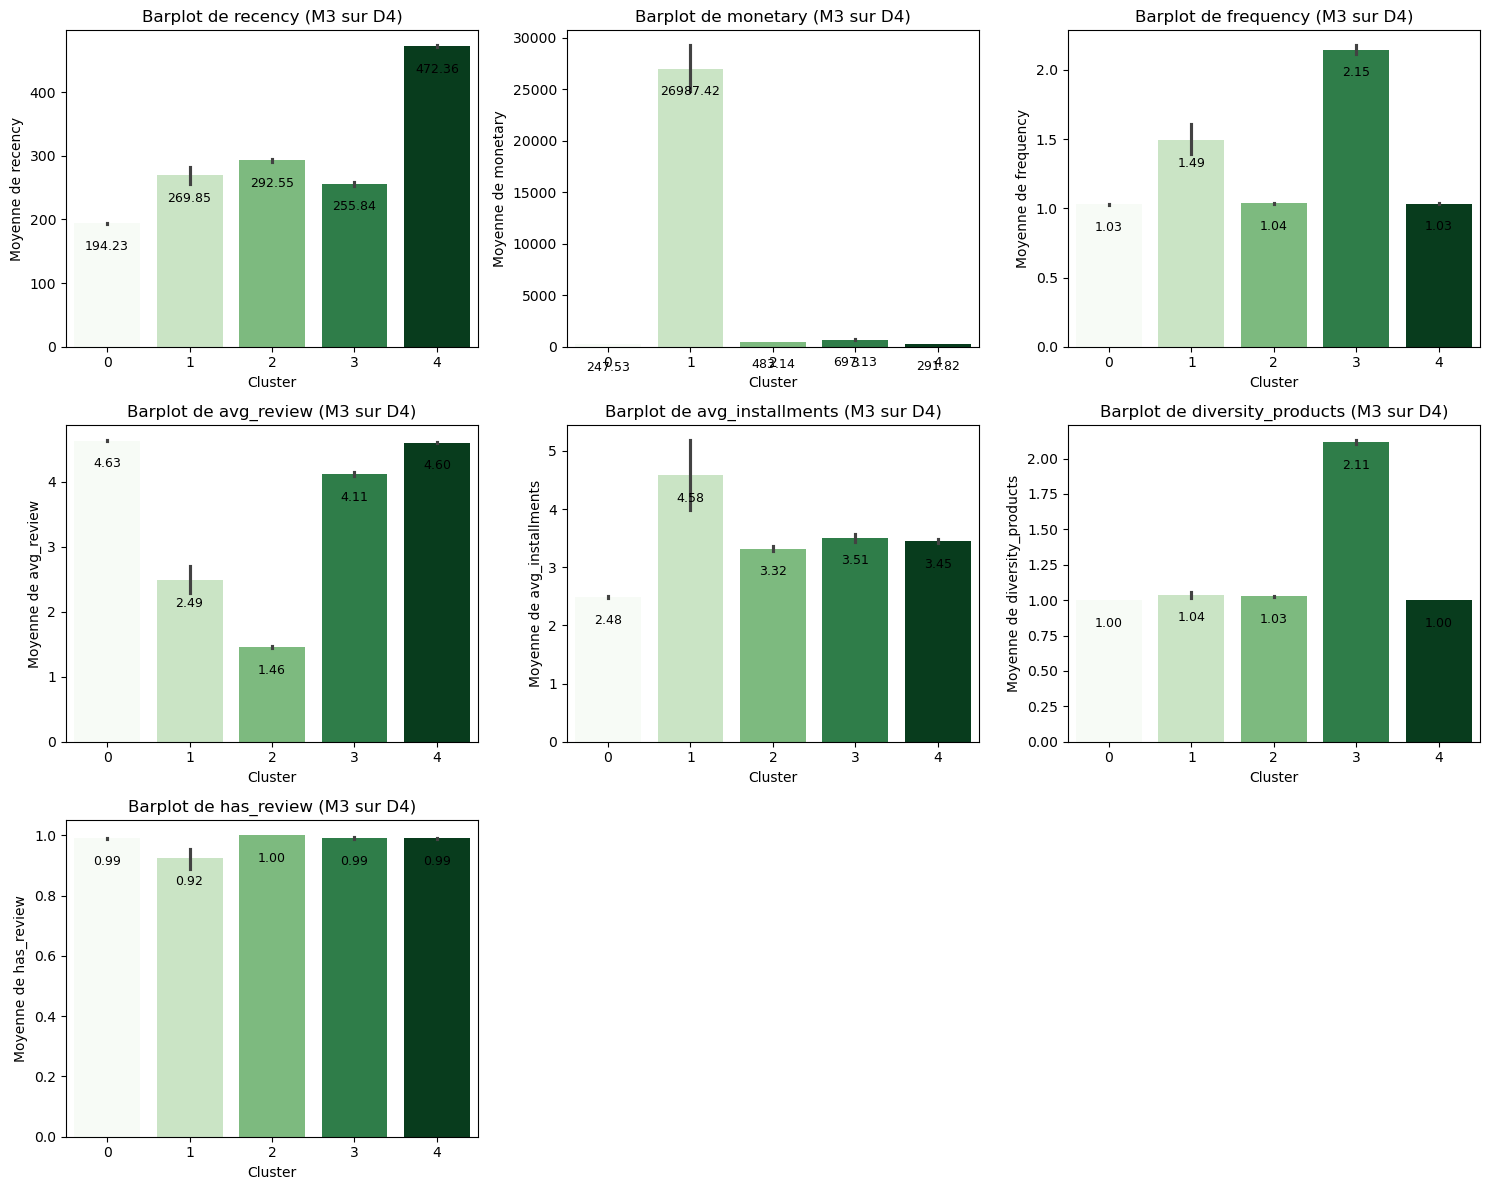

In [112]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M3 sur D4
    sns.barplot(
        data=df_D4,
        x="Cluster_M3",
        y=feature,
        hue="Cluster_M3",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M3 sur D4)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

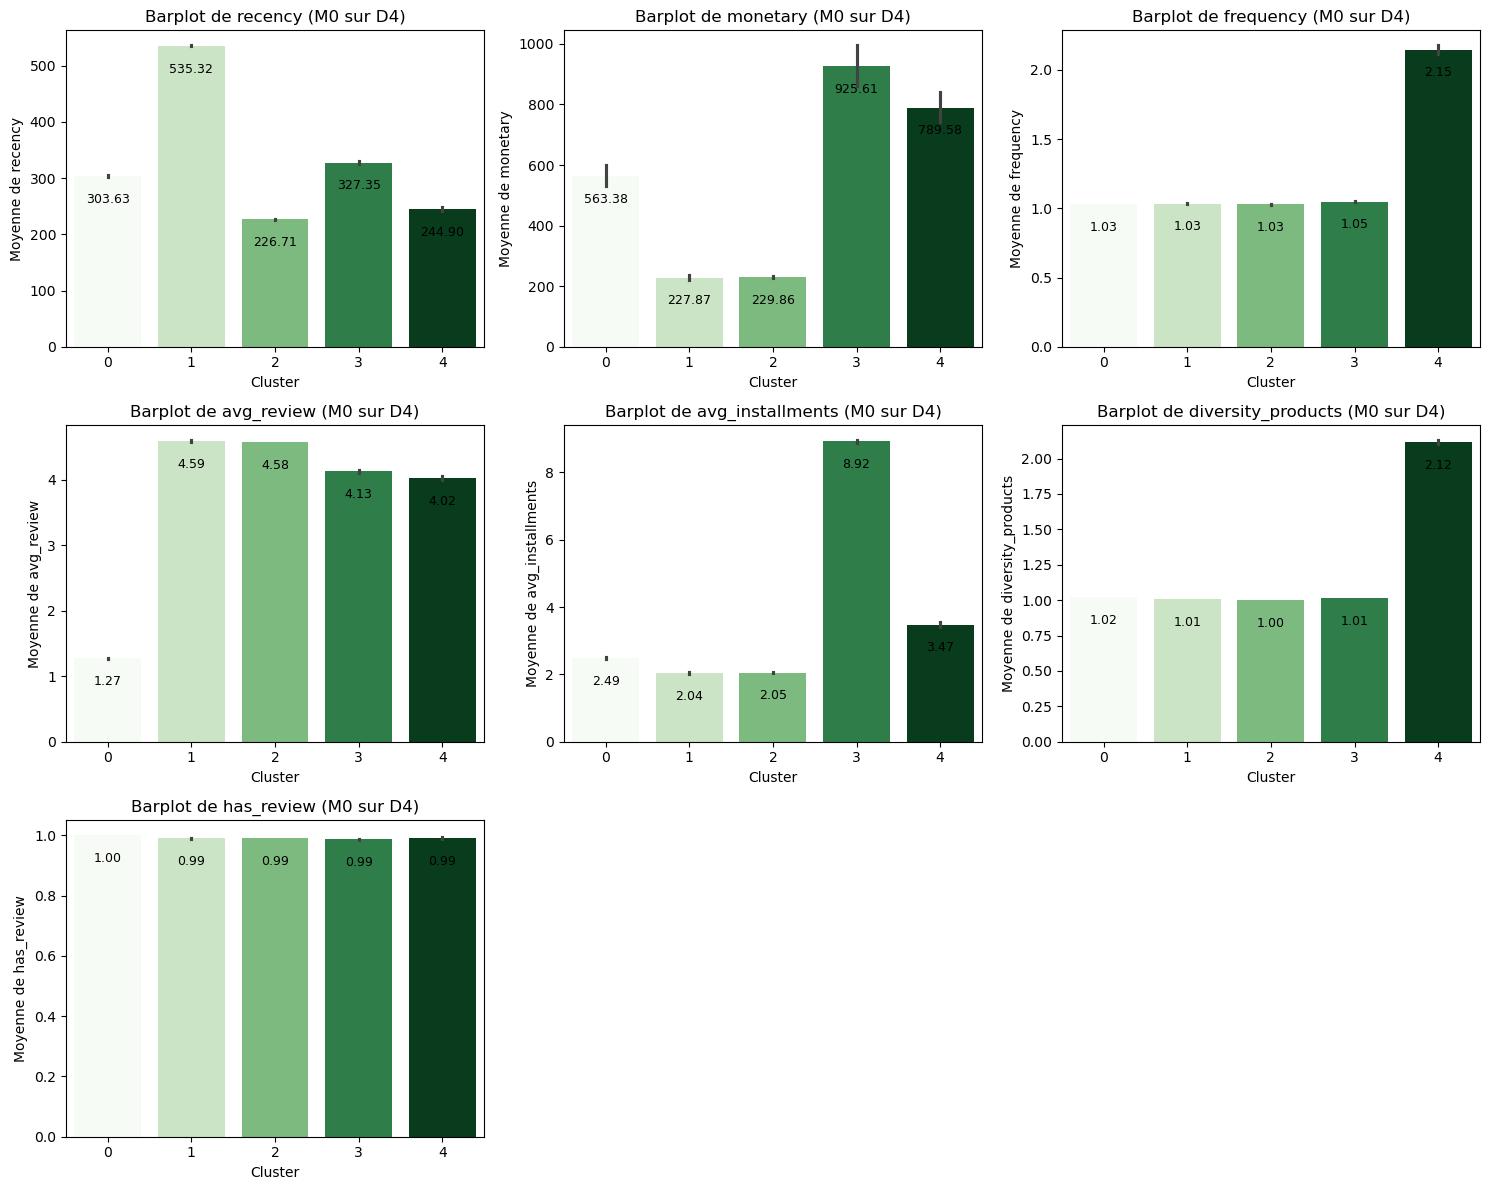

In [113]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M0 sur D4
    sns.barplot(
        data=df_D4,
        x="Cluster_M0",
        y=feature,
        hue="Cluster_M0",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M0 sur D4)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

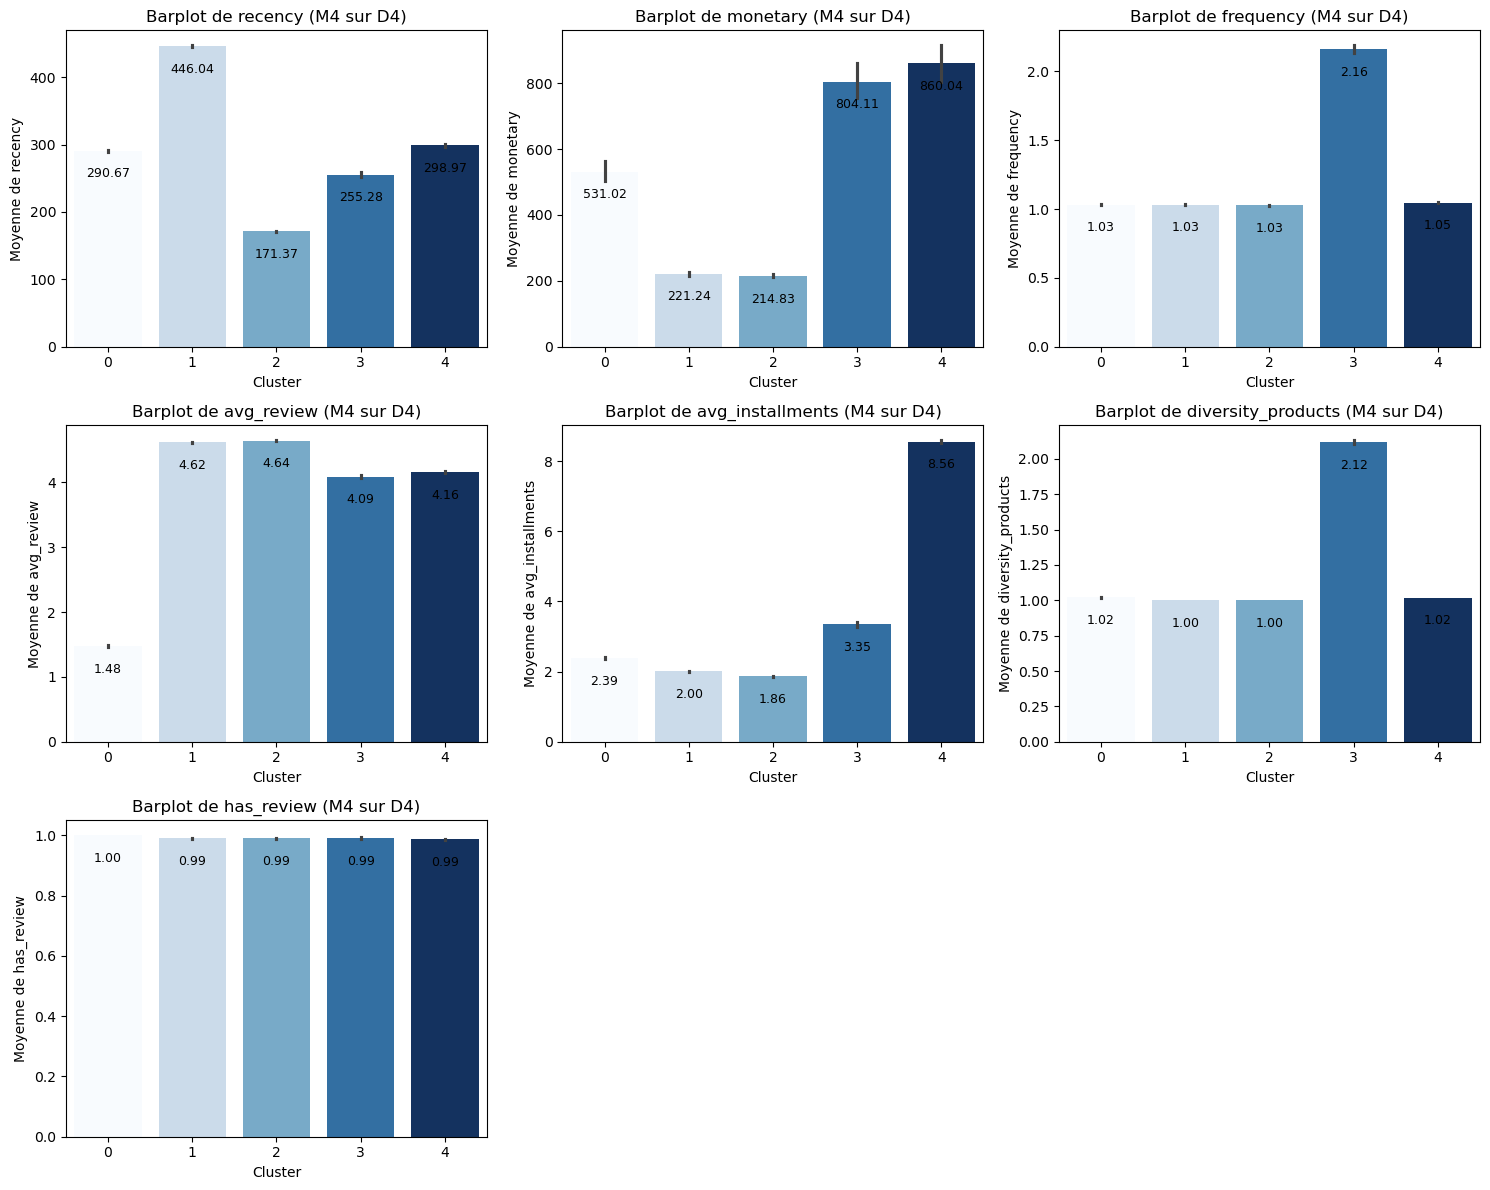

In [114]:
# M4 sur D4
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M4 sur D4
    sns.barplot(
        data=df_D4,
        x="Cluster_M4",
        y=feature,
        hue="Cluster_M4",
        palette="Blues",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M4 sur D4)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### d. ARI

Rappel: L'Adjusted Rand Index (ARI) est une métrique qui mesure la similarité entre deux partitions (deux attributions de clusters) en prenant en compte le hasard. Il varie entre -1 et 1 :

- ARI = 1 => Les deux partitions sont identiques (chaque client a été classé exactement dans le même cluster dans les deux périodes).
- ARI = 0 => La partition est aléatoire, pas meilleure que du hasard.
- ARI < 0 => Les clusters sont moins bien que du hasard, ce qui est rare en pratique

- Pour utiliser l'ARI il faut absolument faire la comparaison sur les clients communs aux deux périodes

In [117]:
# --- 3. Calcul de l'ARI entre M0 et M3 sur D4 ---
ari_M0_M4 = adjusted_rand_score(df_D4["Cluster_M0"], df_D4["Cluster_M4"])
print(f"ARI entre M0 et M4 sur D4 : {ari_M0_M4:.4f}")

ARI entre M0 et M4 sur D4 : 0.5074


In [118]:
# --- 3. Calcul de l'ARI entre M3 et M4 sur D4 ---
ari_M3_M4 = adjusted_rand_score(df_D4["Cluster_M3"], df_D4["Cluster_M4"])
print(f"ARI entre M0 et M4 sur D4 : {ari_M3_M4:.4f}")

ARI entre M0 et M4 sur D4 : 0.5848


### e. Test de Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov permet de comparer si deux distributions sont significativement différentes.

- p-value > 0.05 : On ne rejette pas l’hypothèse que les distributions sont similaires (pas de changement significatif).
- p-value < 0.05 : On rejette l’hypothèse de similarité, donc la distribution a changé entre les périodes.

Ici , permet de voir si les distributions des variables au sein des clusters ont changé entre M0D1 et M1D1. Est-ce que chaque cluster contient encore les mêmes types d'observations ? Ou bien les clusters ont-ils changé de nature, en regroupant des profils différents ?
Si les distributions sont similaires = les clusters ont juste été renommés ou réorganisés.
Si elles sont différentes = la nature des clusters a changé, donc l’algorithme a trouvé de nouvelles structures dans les données.


In [121]:
ks_results = {}

print("\nComparaison des distributions entre M0D4 et M4D4 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D4_M0 = df_D4[df_D4["Cluster_M0"] == cluster]
    df_D4_M4 = df_D4[df_D4["Cluster_M4"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D4_M0[feature], df_D4_M4[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M0D4 et M4D4."
            )
        else:
            print("Aucune différence significative entre M0D4 et M4D4.")
        print("-" * 50)


Comparaison des distributions entre M0D4 et M4D4 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.0760
  -> p-value: 0.0000
La distribution est significativement différente entre M0D4 et M4D4.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.0111
  -> p-value: 0.2063
Aucune différence significative entre M0D4 et M4D4.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0012
  -> p-value: 1.0000
Aucune différence significative entre M0D4 et M4D4.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.1071
  -> p-value: 0.0000
La distribution est significativement différente entre M0D4 et M4D4.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0197
  -> p-value: 0.0016
La distribution est significativement différente entre M0D4 et M4D4.
--------------------------------------------------
Feature: divers

In [122]:
ks_results = {}

print("\nComparaison des distributions entre M3D4 et M4D4 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D4_M3 = df_D4[df_D4["Cluster_M3"] == cluster]
    df_D4_M4 = df_D4[df_D4["Cluster_M4"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D4_M3[feature], df_D4_M4[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M3D4 et M4D4."
            )
        else:
            print("Aucune différence significative entre M3D4 et M4D4.")
        print("-" * 50)


Comparaison des distributions entre M3D4 et M4D4 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.3099
  -> p-value: 0.0000
La distribution est significativement différente entre M3D4 et M4D4.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.1272
  -> p-value: 0.0000
La distribution est significativement différente entre M3D4 et M4D4.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0041
  -> p-value: 0.9621
Aucune différence significative entre M3D4 et M4D4.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.9318
  -> p-value: 0.0000
La distribution est significativement différente entre M3D4 et M4D4.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0336
  -> p-value: 0.0000
La distribution est significativement différente entre M3D4 et M4D4.
-------------------------------------------------

## Période du 04/09/2016 au 17/10/2018

### a. Sélection de la période

In [125]:
# Sélectionner la période 5
mask_D5 = (df_final["order_purchase_timestamp"] >= "2016-09-04") & (
    df_final["order_purchase_timestamp"] <= "2018-10-17"
)
df_D5 = df_final[mask_D5].copy()
df_D5_features = df_D5[features]

# Vérification
print("Shape des données D5 :", df_D5.shape)

Shape des données D5 : (119143, 13)


### b. Lancement du modèle

In [127]:
# 1. Application de M4 sur D5 (seulement transformation)

# Appliquer la transformation de M4 sur D5
X_D5_transformed_M4 = pipeline_M4.named_steps["preprocessor"].transform(df_D5_features)
# Vérification
print("Shape de X_D5_transformed_M4 :", X_D5_transformed_M4.shape)

# Prédiction des clusters avec M4
clusters_D5_M4 = pipeline_M4.named_steps["kmeans"].predict(X_D5_transformed_M4)
df_D5["Cluster_M4"] = clusters_D5_M4

# Vérification
print("Distribution des clusters M4 sur D5 :")
print(df_D5["Cluster_M4"].value_counts().sort_index())

Shape de X_D5_transformed_M4 : (119143, 7)
Distribution des clusters M4 sur D5 :
Cluster_M4
0    19608
1    32838
2    44899
3     6248
4    15550
Name: count, dtype: int64


In [128]:
# 1. Application de M0 sur D5 (seulement transformation)

# Appliquer la transformation de M0 sur D5
X_D5_transformed_M0 = pipeline.named_steps["preprocessor"].transform(df_D5_features)
# Vérification
print("Shape de X_D5_transformed_M0 :", X_D5_transformed_M0.shape)

# Prédiction des clusters avec M0
clusters_D5_M0 = pipeline.named_steps["kmeans"].predict(X_D5_transformed_M0)
df_D5["Cluster_M0"] = clusters_D5_M0

# Vérification
print("Distribution des clusters M0 sur D5 :")
print(df_D5["Cluster_M0"].value_counts().sort_index())

Shape de X_D5_transformed_M0 : (119143, 7)
Distribution des clusters M0 sur D5 :
Cluster_M0
0    17160
1    14656
2    67921
3    13076
4     6330
Name: count, dtype: int64


In [129]:
# 2. Création et fit du nouveau modèle M5 sur D5
# Construction et entraînement du pipeline M5
# Fit de la pipeline M5 sur D5

pipeline_M5 = build_pipeline()
X_D5_transformed_M5 = pipeline_M5.fit_transform(df_D5_features)
clusters_D5_M5 = pipeline_M5.named_steps["kmeans"].labels_
df_D5["Cluster_M5"] = clusters_D5_M5

# Vérification
print("Distribution des clusters M5 sur D5 :")
print(df_D5["Cluster_M5"].value_counts().sort_index())

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.2s
Distribution des clusters M5 sur D5 :
Cluster_M5
0    32830
1    15558
2     6254
3    19595
4    44906
Name: count, dtype: int64


### c. Visualisations

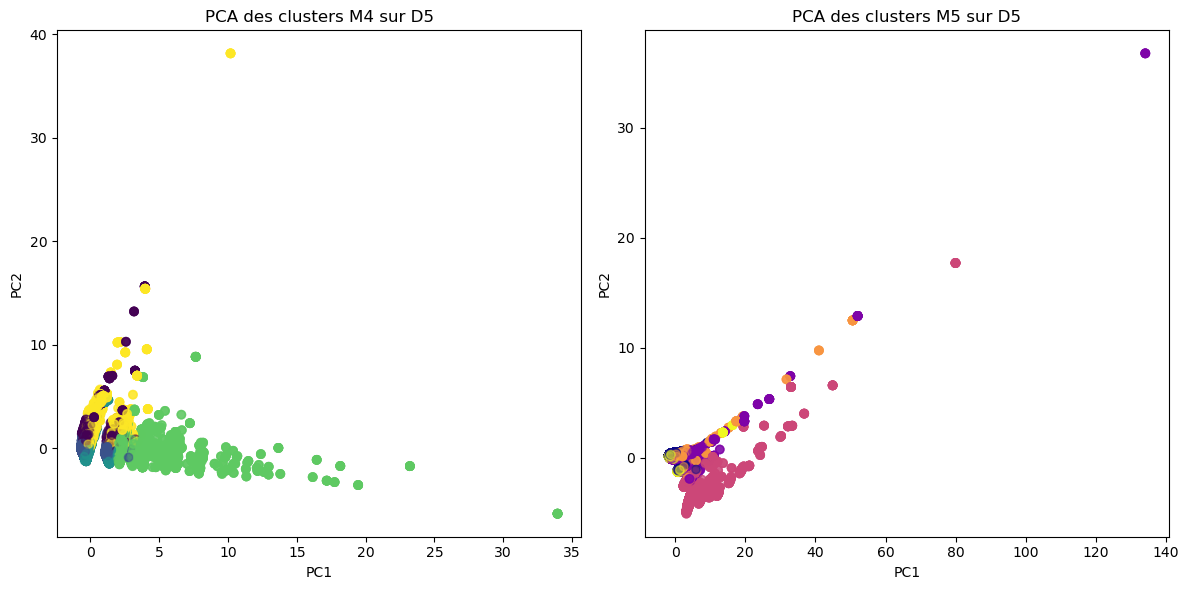

In [131]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D5_pca_M4 = pca.fit_transform(X_D5_transformed_M4)
X_D5_pca_M5 = pca.fit_transform(X_D5_transformed_M5)

# Scatterplot des clusters M4 sur D5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D5_pca_M4[:, 0],
    X_D5_pca_M4[:, 1],
    c=df_D5["Cluster_M4"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M4 sur D5")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M5 sur D5
plt.subplot(1, 2, 2)
plt.scatter(
    X_D5_pca_M5[:, 0],
    X_D5_pca_M5[:, 1],
    c=df_D5["Cluster_M5"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M5 sur D5")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

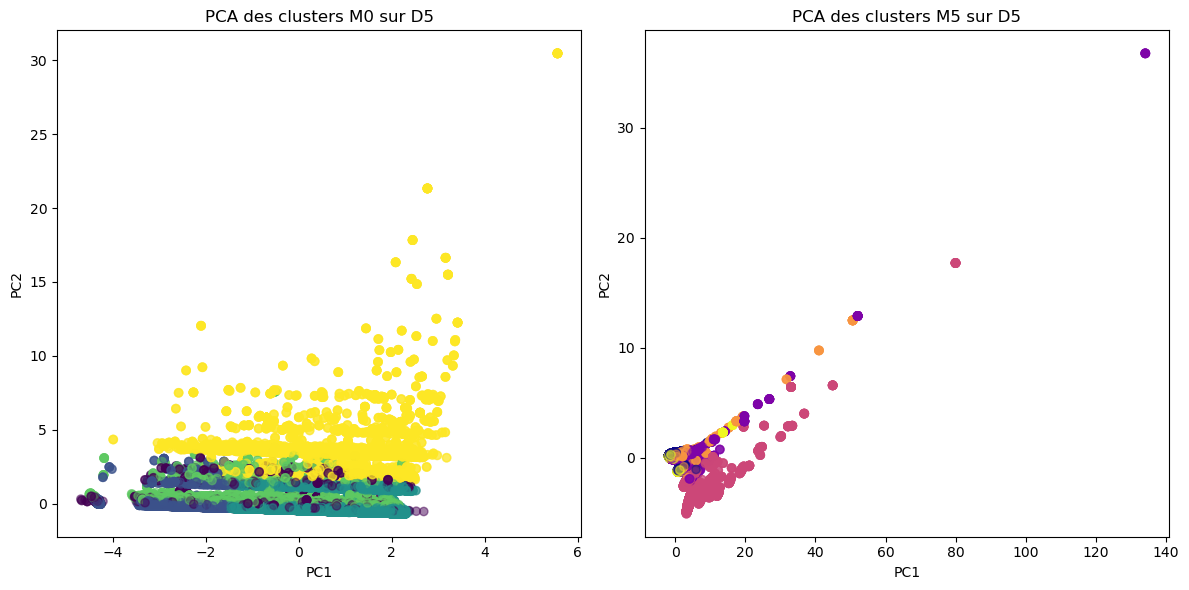

In [132]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_D5_pca_M0 = pca.fit_transform(X_D5_transformed_M0)
X_D5_pca_M5 = pca.fit_transform(X_D5_transformed_M5)

# Scatterplot des clusters M0 sur D5
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    X_D5_pca_M0[:, 0],
    X_D5_pca_M0[:, 1],
    c=df_D5["Cluster_M0"],
    cmap="viridis",
    alpha=0.5,
)
plt.title("PCA des clusters M0 sur D5")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Scatterplot des clusters M5 sur D5
plt.subplot(1, 2, 2)
plt.scatter(
    X_D5_pca_M5[:, 0],
    X_D5_pca_M5[:, 1],
    c=df_D5["Cluster_M5"],
    cmap="plasma",
    alpha=0.5,
)
plt.title("PCA des clusters M5 sur D5")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [133]:
cluster_means_M4D5 = (
    df_D5.groupby("Cluster_M4")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M4D5)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M4                                                              
0           290.606742   1.032079  530.951039    1.475979    1.000000   
1           446.037243   1.032219  221.242134    4.619861    0.990347   
2           171.358583   1.026682  214.866512    4.643734    0.990401   
3           254.833227   2.160051  803.243038    4.086748    0.991037   
4           298.974212   1.046559  860.041859    4.162637    0.987588   

            diversity_products  avg_installments  
Cluster_M4                                        
0                     1.021624          2.391345  
1                     1.000426          2.004324  
2                     1.000000          1.864195  
3                     2.117318          3.343790  
4                     1.017621          8.560772  


- Cluster 0: Clients insatisfaits
- Cluster 1: Clients inactifs
- Cluster 2: Nouveaux clients très satisfaits 
- Cluster 3: Clients achetant fréquemment avec une grande diversité ed produits
- Cluster 4: Clients qui dépenses beaucoup avec un nombre d'échelonnage de paiement élevé

In [135]:
cluster_means_M0D5 = (
    df_D5.groupby("Cluster_M0")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M0D5)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M0                                                              
0           303.546562   1.030828  563.285011    1.273718    1.000000   
1           535.317959   1.034252  227.870218    4.588974    0.990584   
2           226.701683   1.028548  229.884204    4.576950    0.990695   
3           327.352631   1.047645  925.607125    4.129244    0.986923   
4           244.473460   2.147551  788.752218    4.017694    0.991153   

            diversity_products  avg_installments  
Cluster_M0                                        
0                     1.021503          2.487150  
1                     1.005663          2.044965  
2                     1.000000          2.049050  
3                     1.014225          8.919777  
4                     2.114534          3.469352  


- Cluster 0: clients insatisfaits
- Cluster 1: clients inactifs (très satisfaits)
- Cluster 2: clients nouveaux, le moins dépensiers et très satisfaits
- Cluster 3: clients le plus dépensiers et avec le plus d'échelonnage
- Cluster 4: clients achètent le plus fréquemment et le plus de types de produtis

In [137]:
cluster_means_M5D5 = (
    df_D5.groupby("Cluster_M5")[
        [
            "recency",
            "frequency",
            "monetary",
            "avg_review",
            "has_review",
            "diversity_products",
            "avg_installments",
        ]
    ]
    .mean()
    .sort_index()
)


print(cluster_means_M5D5)

               recency  frequency    monetary  avg_review  has_review  \
Cluster_M5                                                              
0           446.027383   1.032105  221.199975    4.619708    0.990344   
1           299.060933   1.046793  859.730316    4.163003    0.987595   
2           254.892549   2.158938  803.046476    4.084746    0.991046   
3           290.630875   1.032100  531.140333    1.475427    1.000000   
4           171.366521   1.026678  214.849132    4.643477    0.990402   

            diversity_products  avg_installments  
Cluster_M5                                        
0                     1.000366          2.003442  
1                     1.017612          8.559519  
2                     2.117205          3.345379  
3                     1.021434          2.390533  
4                     1.000000          1.864194  


- Cluster 0: Clients inactifs
- Cluster 1: Clients le plus dépensiers avec beaucoup d'échelonnage
- Cluster 2: Clients achètent fréquemment avec une grande diversité de produits
- Cluster 3: Clients insatisfaits
- Cluster 4: Clients nouveaux très satisfaits

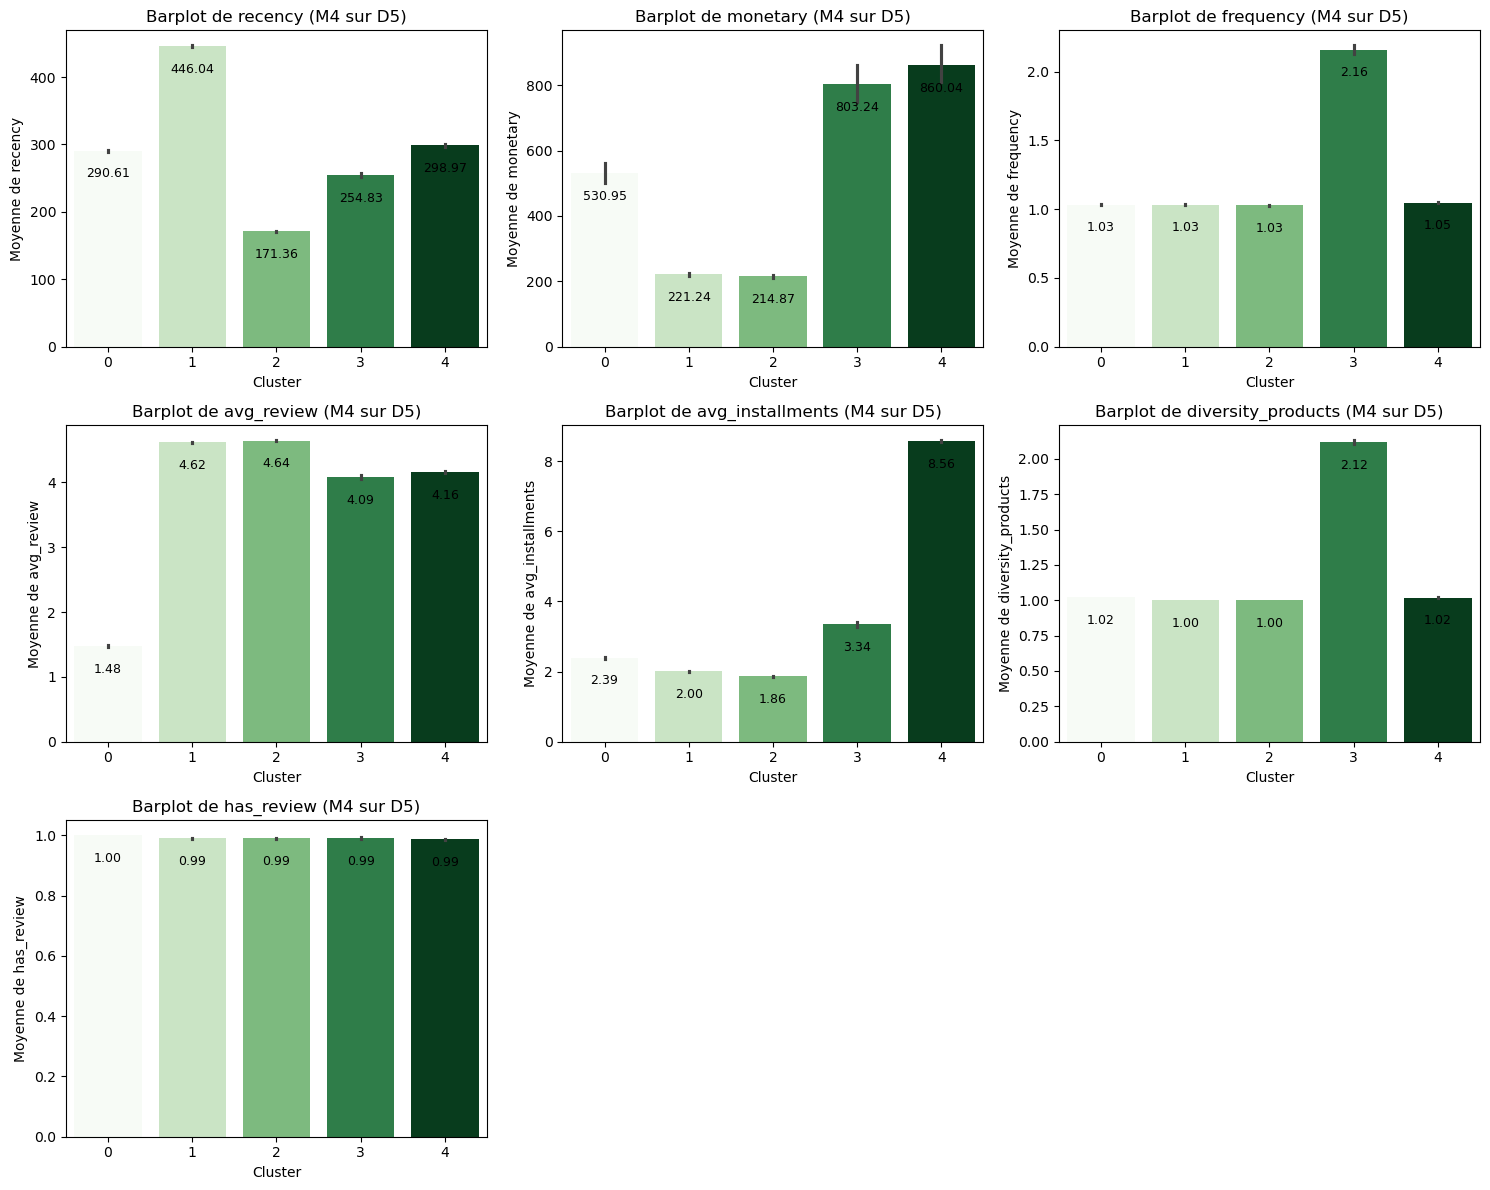

In [139]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M4 sur D5
    sns.barplot(
        data=df_D5,
        x="Cluster_M4",
        y=feature,
        hue="Cluster_M4",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M4 sur D5)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

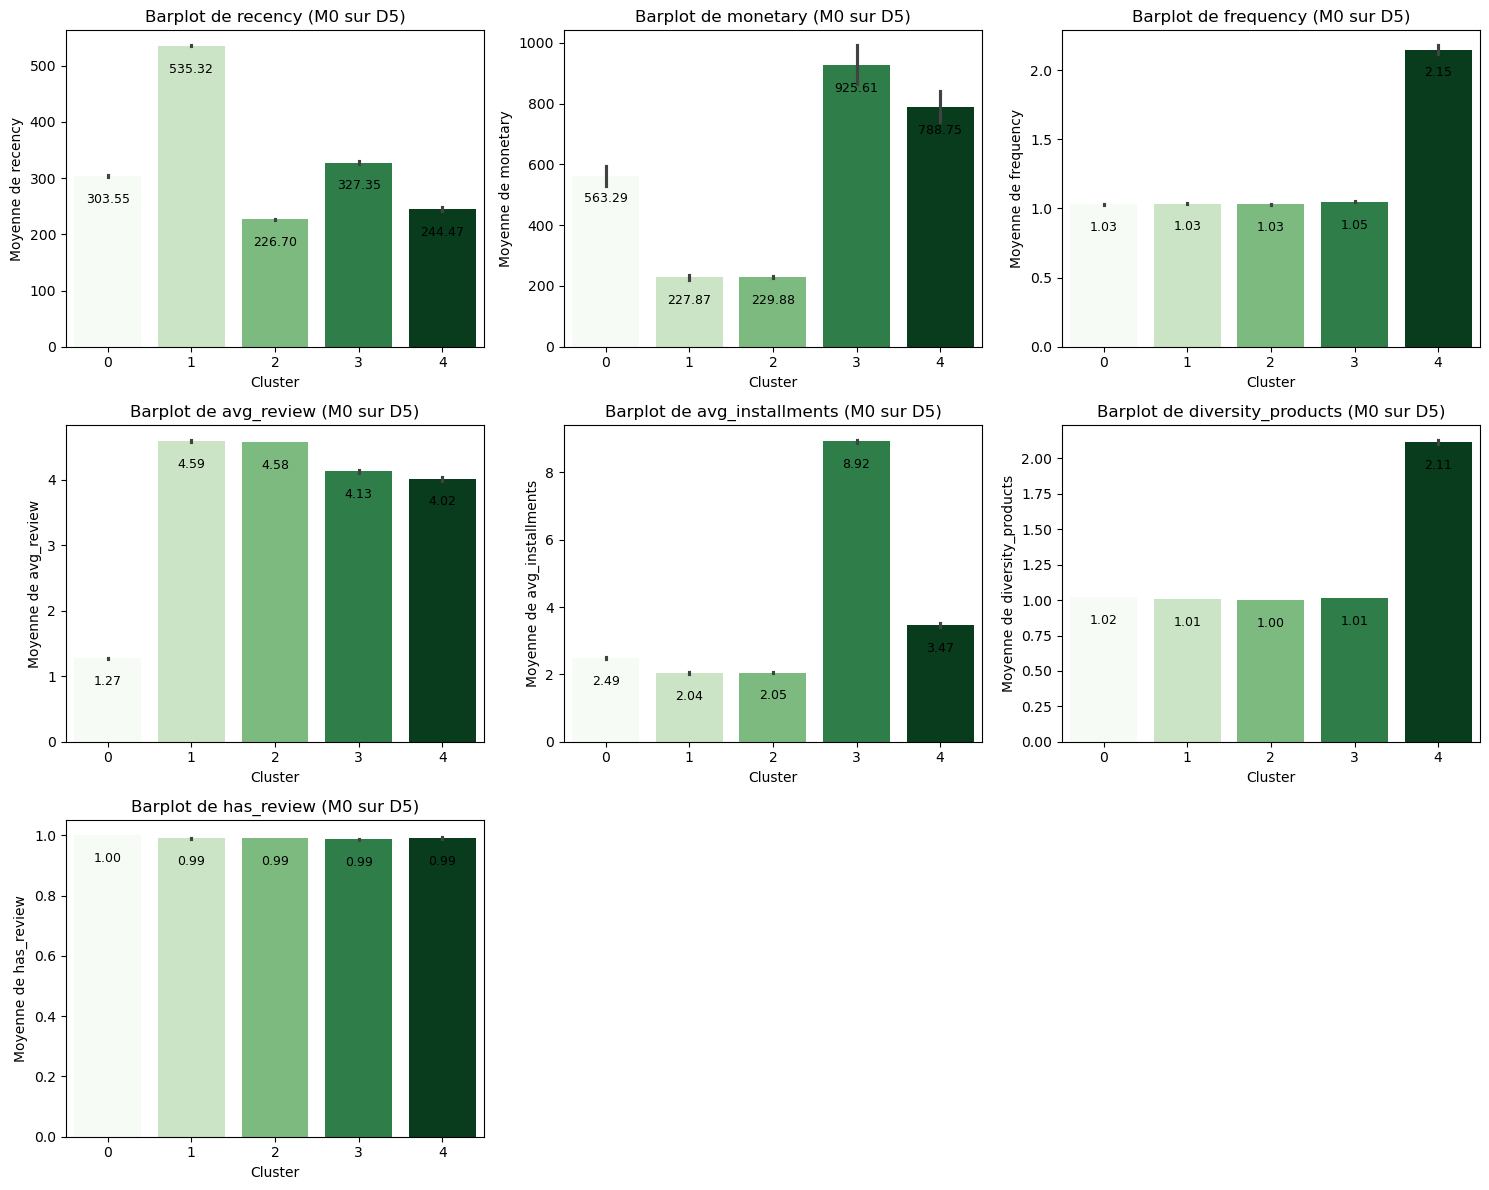

In [140]:
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M0 sur D5
    sns.barplot(
        data=df_D5,
        x="Cluster_M0",
        y=feature,
        hue="Cluster_M0",
        palette="Greens",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M0 sur D5)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

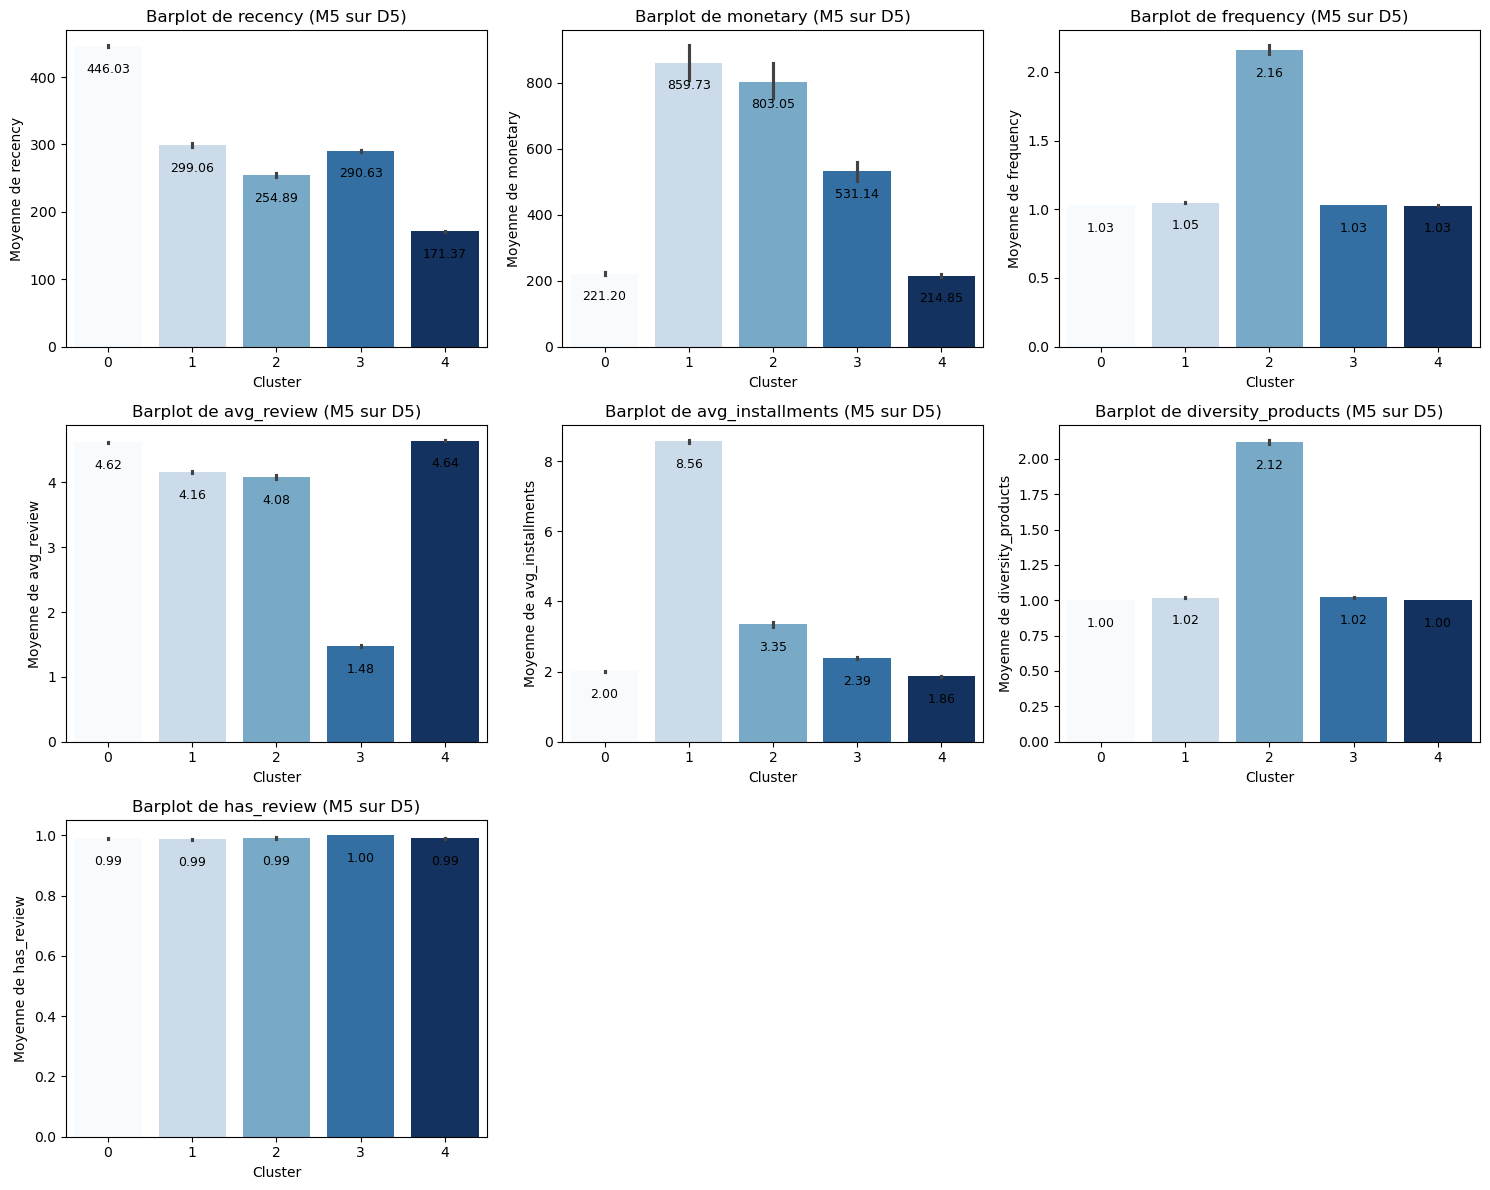

In [141]:
# M4 sur D4
# Définir le nombre de colonnes et de lignes pour organiser les graphiques
n_features = len(features)
n_cols = 3  # Nombre de colonnes par ligne
n_rows = int(np.ceil(n_features / n_cols))  # Calcul du nombre de lignes

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4)
)  # Taille ajustée

# Aplatir la matrice d'axes pour itérer plus facilement
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    # Tracé du barplot pour M5 sur D5
    sns.barplot(
        data=df_D5,
        x="Cluster_M5",
        y=feature,
        hue="Cluster_M5",
        palette="Blues",
        legend=False,
        ax=ax,
    )
    ax.set_title(f"Barplot de {feature} (M5 sur D5)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"Moyenne de {feature}")

    # Annotation des moyennes
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="top",
            fontsize=9,
            color="black",
            xytext=(0, -12),
            textcoords="offset points",
        )

# Supprimer les axes vides si le nombre de features n'est pas un multiple de n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### d. ARI

Rappel: L'Adjusted Rand Index (ARI) est une métrique qui mesure la similarité entre deux partitions (deux attributions de clusters) en prenant en compte le hasard. Il varie entre -1 et 1 :

- ARI = 1 => Les deux partitions sont identiques (chaque client a été classé exactement dans le même cluster dans les deux périodes).
- ARI = 0 => La partition est aléatoire, pas meilleure que du hasard.
- ARI < 0 => Les clusters sont moins bien que du hasard, ce qui est rare en pratique

- Pour utiliser l'ARI il faut absolument faire la comparaison sur les clients communs aux deux périodes

In [144]:
# --- 3. Calcul de l'ARI entre M0 et M5 sur D5 ---
ari_M0_M5 = adjusted_rand_score(df_D5["Cluster_M0"], df_D5["Cluster_M5"])
print(f"ARI entre M0 et M5 sur D5 : {ari_M0_M5:.4f}")

ARI entre M0 et M5 sur D5 : 0.5077


In [145]:
# --- 3. Calcul de l'ARI entre M4 et M5 sur D5 ---
ari_M4_M5 = adjusted_rand_score(df_D5["Cluster_M4"], df_D5["Cluster_M5"])
print(f"ARI entre M4 et M5 sur D5 : {ari_M4_M5:.4f}")

ARI entre M4 et M5 sur D5 : 0.9996


### e. Test de Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov permet de comparer si deux distributions sont significativement différentes.

- p-value > 0.05 : On ne rejette pas l’hypothèse que les distributions sont similaires (pas de changement significatif).
- p-value < 0.05 : On rejette l’hypothèse de similarité, donc la distribution a changé entre les périodes.

Ici , permet de voir si les distributions des variables au sein des clusters ont changé entre M0D1 et M1D1. Est-ce que chaque cluster contient encore les mêmes types d'observations ? Ou bien les clusters ont-ils changé de nature, en regroupant des profils différents ?
Si les distributions sont similaires = les clusters ont juste été renommés ou réorganisés.
Si elles sont différentes = la nature des clusters a changé, donc l’algorithme a trouvé de nouvelles structures dans les données.


In [148]:
ks_results = {}

print("\nComparaison des distributions entre M4D5 et M5D5 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D5_M4 = df_D5[df_D5["Cluster_M4"] == cluster]
    df_D5_M5 = df_D5[df_D5["Cluster_M5"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D5_M4[feature], df_D5_M5[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M4D5 et M5D5."
            )
        else:
            print("Aucune différence significative entre M4D5 et M5D5.")
        print("-" * 50)


Comparaison des distributions entre M4D5 et M5D5 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.5862
  -> p-value: 0.0000
La distribution est significativement différente entre M4D5 et M5D5.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.1599
  -> p-value: 0.0000
La distribution est significativement différente entre M4D5 et M5D5.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0004
  -> p-value: 1.0000
Aucune différence significative entre M4D5 et M5D5.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.9306
  -> p-value: 0.0000
La distribution est significativement différente entre M4D5 et M5D5.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0655
  -> p-value: 0.0000
La distribution est significativement différente entre M4D5 et M5D5.
-------------------------------------------------

In [149]:
ks_results = {}

print("\nComparaison des distributions entre M0D5 et M5D5 :")
for cluster in range(5):  # Boucle sur chaque cluster
    print(f"\nComparaison pour le Cluster {cluster}:")
    df_D5_M0 = df_D5[df_D5["Cluster_M0"] == cluster]
    df_D5_M5 = df_D5[df_D5["Cluster_M5"] == cluster]

    ks_results[cluster] = {}

    for feature in features:
        stat, p_value = ks_2samp(df_D5_M0[feature], df_D5_M5[feature])
        ks_results[cluster][feature] = {"KS Statistic": stat, "p-value": p_value}

        print(f"Feature: {feature}")
        print(f"  -> KS Statistic: {stat:.4f}")
        print(f"  -> p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(
                "La distribution est significativement différente entre M0D5 et M5D5."
            )
        else:
            print("Aucune différence significative entre M0D5 et M5D5.")
        print("-" * 50)


Comparaison des distributions entre M0D5 et M5D5 :

Comparaison pour le Cluster 0:
Feature: recency
  -> KS Statistic: 0.5432
  -> p-value: 0.0000
La distribution est significativement différente entre M0D5 et M5D5.
--------------------------------------------------
Feature: monetary
  -> KS Statistic: 0.1692
  -> p-value: 0.0000
La distribution est significativement différente entre M0D5 et M5D5.
--------------------------------------------------
Feature: frequency
  -> KS Statistic: 0.0008
  -> p-value: 1.0000
Aucune différence significative entre M0D5 et M5D5.
--------------------------------------------------
Feature: avg_review
  -> KS Statistic: 0.9545
  -> p-value: 0.0000
La distribution est significativement différente entre M0D5 et M5D5.
--------------------------------------------------
Feature: avg_installments
  -> KS Statistic: 0.0847
  -> p-value: 0.0000
La distribution est significativement différente entre M0D5 et M5D5.
-------------------------------------------------

1. Cluster 0 :
Différences significatives pour recency, monetary, avg_review, avg_installments, diversity_products.
Aucune différence pour frequency et has_review.
2. Cluster 1 :
Différences significatives pour recency, monetary, avg_review, avg_installments.
Aucune différence pour frequency, diversity_products et has_review.
3. Cluster 2 :
Différences significatives pour recency, monetary, frequency, avg_review, avg_installments, diversity_products.
Aucune différence pour has_review.
4. Cluster 3 :
Différences significatives pour recency, monetary, avg_review, avg_installments.
Aucune différence pour frequency, diversity_products et has_review.
5. Cluster 4 :
Différences significatives pour recency, monetary, frequency, avg_review, avg_installments, diversity_products.
Aucune différence pour has_review.


Analyse Globale :

- Les features "recency" et "monetary" sont toujours significativement différentes entre M0D5 et M5D5 pour tous les clusters.
- "Avg_review" et "avg_installments" montrent souvent des différences, sauf dans certains clusters spécifiques.
- "Diversity_products" est majoritairement différent, sauf dans les clusters 1 et 3.
- "Has_review" ne présente aucune différence significative dans tous les clusters.
- "Frequency" est parfois différent (clusters 2 et 4) mais pas dans les clusters 0, 1 et 3.

### Courbe ARI - tous les 2 mois

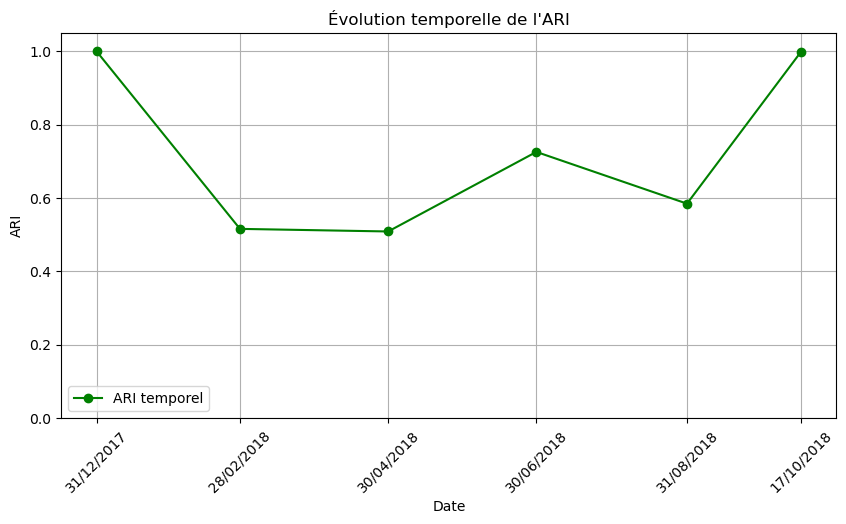

In [262]:
# Ici évolution relative de l'ARI

# Dates des comparaisons
dates = [
    "31/12/2017",
    "28/02/2018",
    "30/04/2018",
    "30/06/2018",
    "31/08/2018",
    "17/10/2018",
]

# Valeurs des ARI correspondantes
ari_values = [ari_M0M0, ari_M0M1, ari_M1_M2, ari_M2_M3, ari_M3_M4, ari_M4_M5]

# Convertir les dates en format lisible pour matplotlib
dates = [pd.to_datetime(date, format="%d/%m/%Y") for date in dates]

# Tracé du graphique
plt.figure(figsize=(10, 5))
plt.plot(dates, ari_values, marker="o", linestyle="-", color="green", label="ARI temporel")

# Ajout des labels et titre
plt.xlabel("Date")
plt.ylabel("ARI")
plt.ylim(0, 1.05)  # Fixer l'échelle de l'axe Y entre 0 et 1
plt.title("Évolution temporelle de l'ARI")
plt.xticks(dates, [date.strftime("%d/%m/%Y") for date in dates], rotation=45)
plt.legend()
plt.legend()
plt.grid()

# Affichage des dates complètes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
  # Format JJ/MM/AAAA

# Affichage du graphique
plt.show()

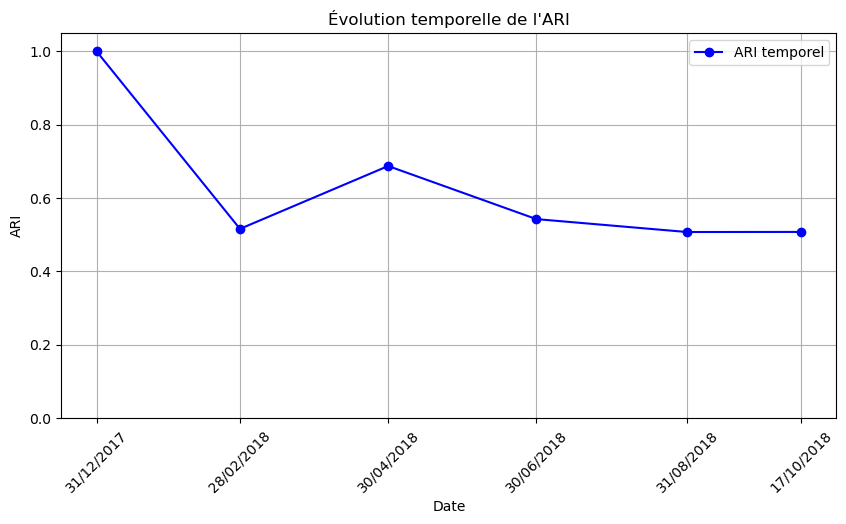

In [260]:
# Dates des comparaisons
dates = [
    "31/12/2017",
    "28/02/2018",
    "30/04/2018",
    "30/06/2018",
    "31/08/2018",
    "17/10/2018",
]

# Valeurs des ARI correspondantes
ari_values = [ari_M0M0, ari_M0M1, ari_M0_M2, ari_M0_M3, ari_M0_M4, ari_M0_M5]

# Convertir les dates en format lisible pour matplotlib
dates = [pd.to_datetime(date, format="%d/%m/%Y") for date in dates]

# Tracé du graphique
plt.figure(figsize=(10, 5))
plt.plot(dates, ari_values, marker="o", linestyle="-", color="b", label="ARI temporel")

# Ajout des labels et titre
plt.xlabel("Date")
plt.ylabel("ARI")
plt.ylim(0, 1.05)
plt.title("Évolution temporelle de l'ARI")

# Affichage des dates complètes
plt.gca().xaxis.set_major_formatter(
    mdates.DateFormatter("%d/%m/%Y")
)  # Format JJ/MM/AAAA
plt.xticks(dates, [date.strftime("%d/%m/%Y") for date in dates], rotation=45)
plt.legend()
plt.grid()

# Affichage du graphique
plt.show()

## Automatisation pour tester un contrat de maintenance trimestriel


=== Période : 2016-09-04 -> 2017-12-31 ===
Shape des données pour la période : (54958, 13)
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
ARI M0 vs Mₓ (2017-12-31) : 1.0000
Pas de modèle précédent pour comparaison.
Moyennes des features pour la période 2017-12-31:
                recency  frequency    monetary  avg_review  has_review  \
Cluster_new                                                              
0            422.765053   1.034562  516.733834    1.384453    1.000000   
1            535.317959   1.034252  227.870218    4.588974    0.990584   
2            357.701512   1.034139  222.309249    4.607282    0.989688   
3            430.510633   1.054201  930.430749    4.160043    0.984699   
4            341.576255   2.265005  578.345625    4.170790    0.987865   

             diversity_products  avg_installments  
Cluster_new                                        
0               

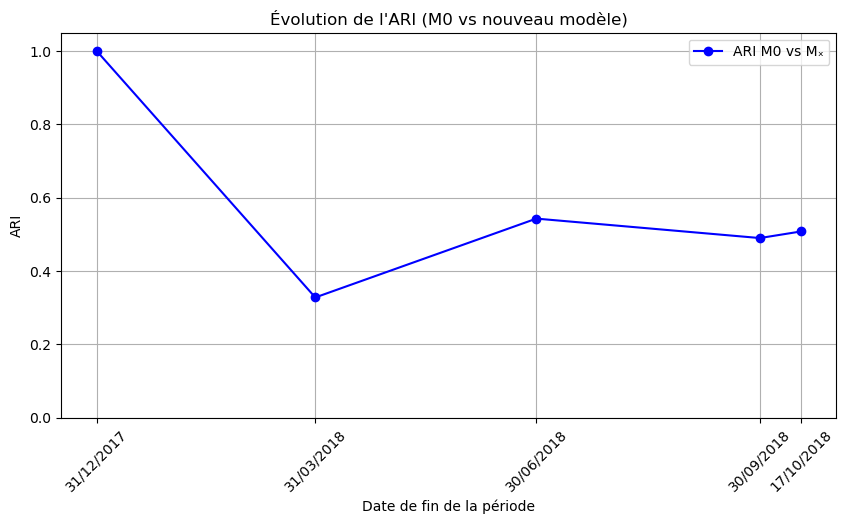

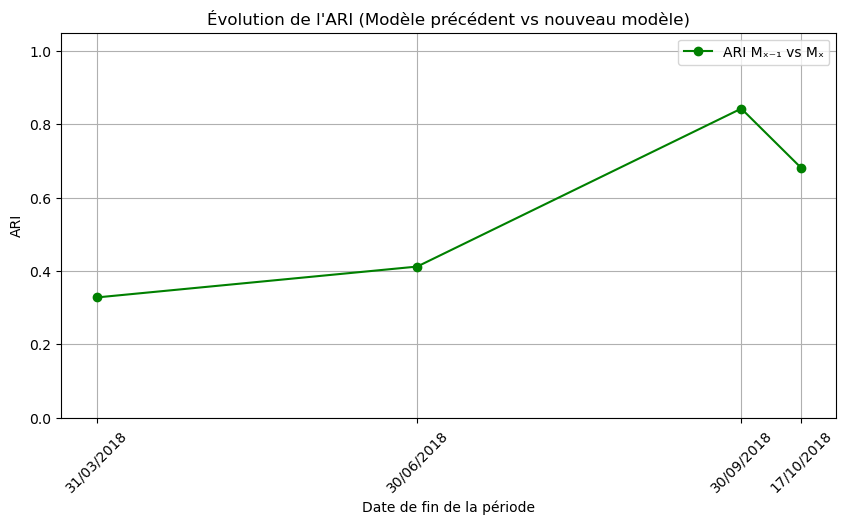


Analyse terminée.


In [156]:
# --- Paramètres globaux ---
start_date = pd.to_datetime("2016-09-04")
reference_end = pd.to_datetime("2017-12-31")  # Fin de la période de référence M0
final_date = pd.to_datetime("2018-10-17")
df_final["order_purchase_timestamp"] = pd.to_datetime(
    df_final["order_purchase_timestamp"]
)

# Initialisation des variables
pipeline_prev = None
current_end = reference_end

dates = []  # Pour stocker les dates de fin de période
ari_M0_list = []  # ARI entre M0 et le nouveau modèle
ari_prev_list = []  # ARI entre le modèle précédent et le nouveau modèle
results = {}
cluster_means_dict = {}  # Pour stocker les moyennes par période (optionnel)

# --- Boucle d'analyse ---
while True:
    period_label = current_end.strftime("%Y-%m-%d")
    print(f"\n=== Période : {start_date.strftime('%Y-%m-%d')} -> {period_label} ===")

    # 1. Extraction des données pour la période courante
    mask = (df_final["order_purchase_timestamp"] >= start_date) & (
        df_final["order_purchase_timestamp"] <= current_end
    )
    df_period = df_final[mask].copy()
    df_period_features = df_period[features]
    print(f"Shape des données pour la période : {df_period.shape}")

    # 2. Application du modèle de référence M0
    X_transformed_M0 = pipeline.named_steps["preprocessor"].transform(
        df_period_features
    )
    clusters_M0 = pipeline.named_steps["kmeans"].predict(X_transformed_M0)
    df_period["Cluster_M0"] = clusters_M0

    # 3. Création et fit d'un nouveau modèle sur la période (Mₓ)
    pipeline_new = build_pipeline()
    X_transformed_new = pipeline_new.fit_transform(df_period_features)
    clusters_new = pipeline_new.named_steps["kmeans"].labels_
    df_period["Cluster_new"] = clusters_new

    # 4. Calcul de l'ARI entre M0 et le nouveau modèle
    ari_M0 = adjusted_rand_score(df_period["Cluster_M0"], df_period["Cluster_new"])
    print(f"ARI M0 vs Mₓ ({period_label}) : {ari_M0:.4f}")

    # 5. Calcul de l'ARI entre le modèle précédent et le nouveau modèle
    if pipeline_prev is not None:
        X_transformed_prev = pipeline_prev.named_steps["preprocessor"].transform(
            df_period_features
        )
        clusters_prev = pipeline_prev.named_steps["kmeans"].predict(X_transformed_prev)
        df_period["Cluster_prev"] = clusters_prev
        ari_prev = adjusted_rand_score(
            df_period["Cluster_prev"], df_period["Cluster_new"]
        )
        print(f"ARI Mₓ₋₁ vs Mₓ ({period_label}) : {ari_prev:.4f}")
    else:
        ari_prev = np.nan
        print("Pas de modèle précédent pour comparaison.")

    # 6. Stockage des résultats
    results[period_label] = df_period.copy()
    dates.append(current_end)
    ari_M0_list.append(ari_M0)
    ari_prev_list.append(ari_prev)

    # 7. Affichage des moyennes des features par clusters
    cluster_means = (
        df_period.groupby("Cluster_new")[
            [
                "recency",
                "frequency",
                "monetary",
                "avg_review",
                "has_review",
                "diversity_products",
                "avg_installments",
            ]
        ]
        .mean()
        .sort_index()
    )
    print(f"Moyennes des features pour la période {period_label}:")
    print(cluster_means)
    cluster_means_dict[period_label] = cluster_means

    # Mise à jour du modèle précédent
    pipeline_prev = pipeline_new

    # Passage à la période suivante
    if current_end == final_date:
        break  # On a atteint la date finale
    next_end = current_end + relativedelta(months=3)
    # S'assurer que la dernière période est exactement final_date
    if next_end > final_date:
        current_end = final_date
    else:
        current_end = next_end

# --- Tracé des graphiques ---

# Conversion des dates en format pour matplotlib
dates = pd.to_datetime(dates)

# Graphique 1 : ARI (M0 vs Mₓ)
plt.figure(figsize=(10, 5))
plt.plot(
    dates, ari_M0_list, marker="o", linestyle="-", color="blue", label="ARI M0 vs Mₓ"
)
plt.ylim(0, 1.05)
plt.xlabel("Date de fin de la période")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI (M0 vs nouveau modèle)")
plt.grid(True)
# Forcer l'affichage exact des dates
plt.xticks(dates, [d.strftime("%d/%m/%Y") for d in dates], rotation=45)
plt.legend()
plt.show()

# Graphique 2 : ARI (Mₓ₋₁ vs Mₓ)
plt.figure(figsize=(10, 5))
# On ignore le premier point (NaN) pour la comparaison avec le modèle précédent
plt.plot(
    dates[1:],
    ari_prev_list[1:],
    marker="o",
    linestyle="-",
    color="green",
    label="ARI Mₓ₋₁ vs Mₓ",
)
plt.ylim(0, 1.05)
plt.xlabel("Date de fin de la période")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI (Modèle précédent vs nouveau modèle)")
plt.grid(True)
plt.xticks(dates[1:], [d.strftime("%d/%m/%Y") for d in dates[1:]], rotation=45)
plt.legend()
plt.show()

print("\nAnalyse terminée.")

## Automatisation pour tester un contrat de maintenance mensuel


=== Période : 2016-09-04 -> 2017-12-31 ===
Shape des données pour la période : (54958, 13)
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
ARI M0 vs Mₓ (2017-12-31) : 1.0000
Pas de modèle précédent pour comparaison.
Moyennes des features pour la période 2017-12-31:
                recency  frequency    monetary  avg_review  has_review  \
Cluster_new                                                              
0            422.765053   1.034562  516.733834    1.384453    1.000000   
1            535.317959   1.034252  227.870218    4.588974    0.990584   
2            357.701512   1.034139  222.309249    4.607282    0.989688   
3            430.510633   1.054201  930.430749    4.160043    0.984699   
4            341.576255   2.265005  578.345625    4.170790    0.987865   

             diversity_products  avg_installments  
Cluster_new                                        
0               

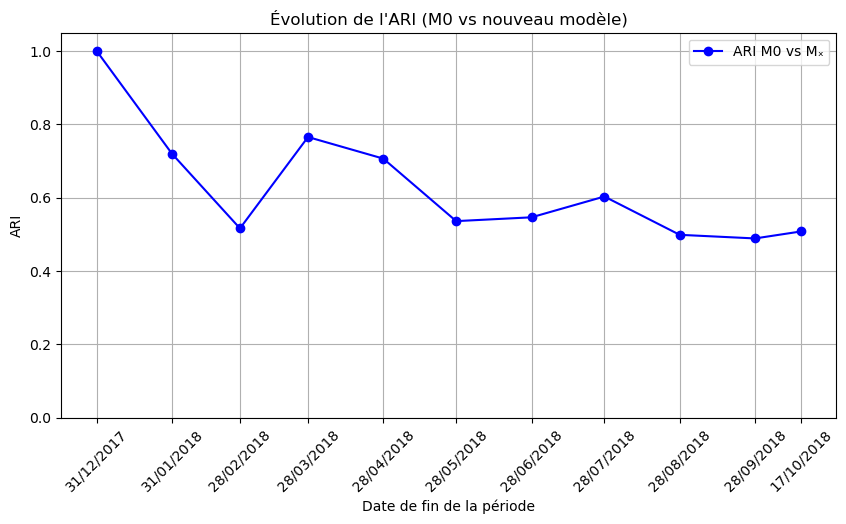

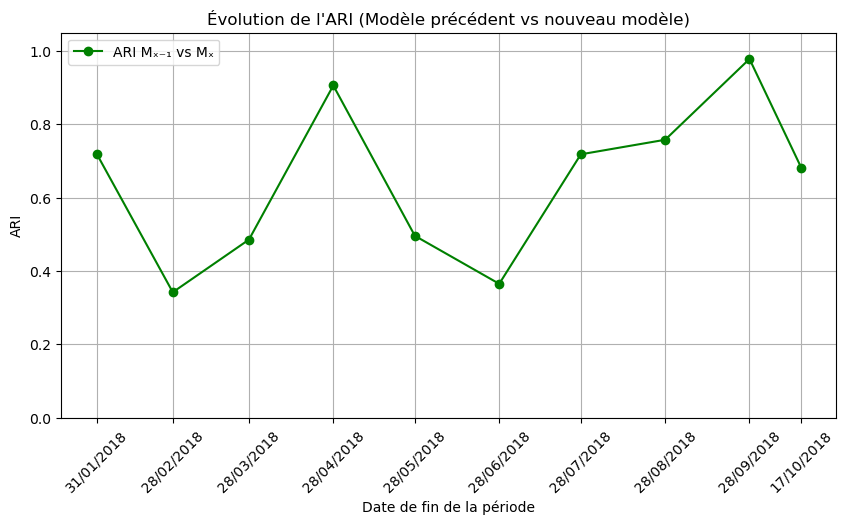


Analyse terminée.


In [158]:
# --- Paramètres globaux ---
start_date = pd.to_datetime("2016-09-04")
reference_end = pd.to_datetime("2017-12-31")  # Fin de la période de référence M0
final_date = pd.to_datetime("2018-10-17")
df_final["order_purchase_timestamp"] = pd.to_datetime(
    df_final["order_purchase_timestamp"]
)

# Initialisation des variables
pipeline_prev = None
current_end = reference_end

dates = []  # Pour stocker les dates de fin de période
ari_M0_list = []  # ARI entre M0 et le nouveau modèle
ari_prev_list = []  # ARI entre le modèle précédent et le nouveau modèle
results = {}
cluster_means_dict = {}  # Pour stocker les moyennes par période (optionnel)

# --- Boucle d'analyse ---
while True:
    period_label = current_end.strftime("%Y-%m-%d")
    print(f"\n=== Période : {start_date.strftime('%Y-%m-%d')} -> {period_label} ===")

    # 1. Extraction des données pour la période courante
    mask = (df_final["order_purchase_timestamp"] >= start_date) & (
        df_final["order_purchase_timestamp"] <= current_end
    )
    df_period = df_final[mask].copy()
    df_period_features = df_period[features]
    print(f"Shape des données pour la période : {df_period.shape}")

    # 2. Application du modèle de référence M0
    X_transformed_M0 = pipeline.named_steps["preprocessor"].transform(
        df_period_features
    )
    clusters_M0 = pipeline.named_steps["kmeans"].predict(X_transformed_M0)
    df_period["Cluster_M0"] = clusters_M0

    # 3. Création et fit d'un nouveau modèle sur la période (Mₓ)
    pipeline_new = build_pipeline()
    X_transformed_new = pipeline_new.fit_transform(df_period_features)
    clusters_new = pipeline_new.named_steps["kmeans"].labels_
    df_period["Cluster_new"] = clusters_new

    # 4. Calcul de l'ARI entre M0 et le nouveau modèle
    ari_M0 = adjusted_rand_score(df_period["Cluster_M0"], df_period["Cluster_new"])
    print(f"ARI M0 vs Mₓ ({period_label}) : {ari_M0:.4f}")

    # 5. Calcul de l'ARI entre le modèle précédent et le nouveau modèle
    if pipeline_prev is not None:
        X_transformed_prev = pipeline_prev.named_steps["preprocessor"].transform(
            df_period_features
        )
        clusters_prev = pipeline_prev.named_steps["kmeans"].predict(X_transformed_prev)
        df_period["Cluster_prev"] = clusters_prev
        ari_prev = adjusted_rand_score(
            df_period["Cluster_prev"], df_period["Cluster_new"]
        )
        print(f"ARI Mₓ₋₁ vs Mₓ ({period_label}) : {ari_prev:.4f}")
    else:
        ari_prev = np.nan
        print("Pas de modèle précédent pour comparaison.")

    # 6. Stockage des résultats
    results[period_label] = df_period.copy()
    dates.append(current_end)
    ari_M0_list.append(ari_M0)
    ari_prev_list.append(ari_prev)

    # 7. Affichage des moyennes des features par clusters
    cluster_means = (
        df_period.groupby("Cluster_new")[
            [
                "recency",
                "frequency",
                "monetary",
                "avg_review",
                "has_review",
                "diversity_products",
                "avg_installments",
            ]
        ]
        .mean()
        .sort_index()
    )
    print(f"Moyennes des features pour la période {period_label}:")
    print(cluster_means)
    cluster_means_dict[period_label] = cluster_means

    # Mise à jour du modèle précédent
    pipeline_prev = pipeline_new

    # Passage à la période suivante
    if current_end == final_date:
        break  # On a atteint la date finale
    next_end = current_end + relativedelta(months=1)
    # S'assurer que la dernière période est exactement final_date
    if next_end > final_date:
        current_end = final_date
    else:
        current_end = next_end

# --- Tracé des graphiques ---

# Conversion des dates en format pour matplotlib
dates = pd.to_datetime(dates)

# Graphique 1 : ARI (M0 vs Mₓ)
plt.figure(figsize=(10, 5))
plt.plot(
    dates, ari_M0_list, marker="o", linestyle="-", color="blue", label="ARI M0 vs Mₓ"
)
plt.ylim(0, 1.05)
plt.xlabel("Date de fin de la période")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI (M0 vs nouveau modèle)")
plt.grid(True)
# Forcer l'affichage exact des dates
plt.xticks(dates, [d.strftime("%d/%m/%Y") for d in dates], rotation=45)
plt.legend()
plt.show()

# Graphique 2 : ARI (Mₓ₋₁ vs Mₓ)
plt.figure(figsize=(10, 5))
# On ignore le premier point (NaN) pour la comparaison avec le modèle précédent
plt.plot(
    dates[1:],
    ari_prev_list[1:],
    marker="o",
    linestyle="-",
    color="green",
    label="ARI Mₓ₋₁ vs Mₓ",
)
plt.ylim(0, 1.05)
plt.xlabel("Date de fin de la période")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI (Modèle précédent vs nouveau modèle)")
plt.grid(True)
plt.xticks(dates[1:], [d.strftime("%d/%m/%Y") for d in dates[1:]], rotation=45)
plt.legend()
plt.show()

print("\nAnalyse terminée.")

## Automatisation pour tester un contrat de maintenance 2 semaines


=== Période : 2016-09-04 -> 2017-12-31 ===
Shape des données pour la période : (54958, 13)
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing kmeans, total=   0.1s
ARI M0 vs Mₓ (2017-12-31) : 1.0000
Pas de modèle précédent pour comparaison.
Moyennes des features pour la période 2017-12-31:
                recency  frequency    monetary  avg_review  has_review  \
Cluster_new                                                              
0            422.765053   1.034562  516.733834    1.384453    1.000000   
1            535.317959   1.034252  227.870218    4.588974    0.990584   
2            357.701512   1.034139  222.309249    4.607282    0.989688   
3            430.510633   1.054201  930.430749    4.160043    0.984699   
4            341.576255   2.265005  578.345625    4.170790    0.987865   

             diversity_products  avg_installments  
Cluster_new                                        
0               

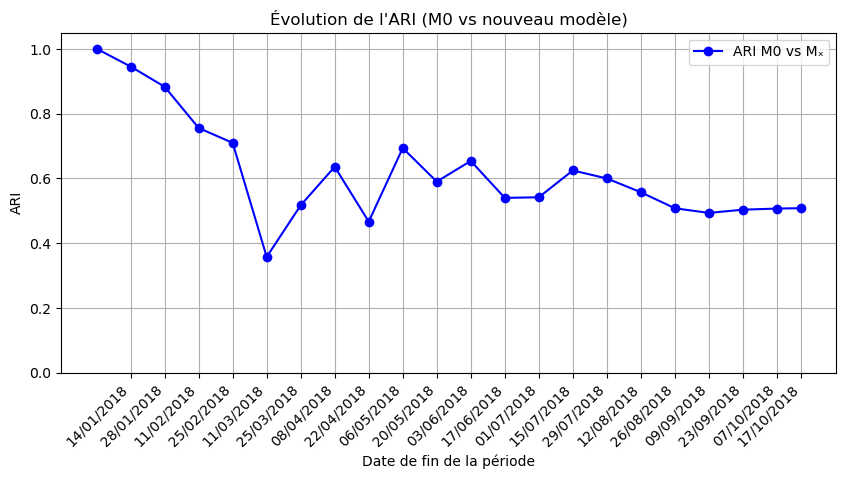

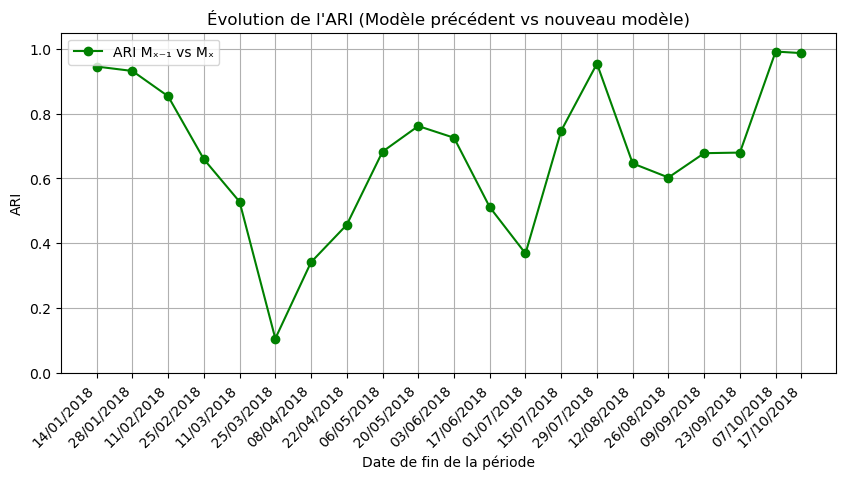


Analyse terminée.


In [160]:
# --- Paramètres globaux ---
start_date = pd.to_datetime("2016-09-04")
reference_end = pd.to_datetime("2017-12-31")  # Fin de la période de référence M0
final_date = pd.to_datetime("2018-10-17")
df_final["order_purchase_timestamp"] = pd.to_datetime(
    df_final["order_purchase_timestamp"]
)


# Initialisation des variables
pipeline_prev = None
current_end = reference_end

dates = []  # Pour stocker les dates de fin de période
ari_M0_list = []  # ARI entre M0 et le nouveau modèle
ari_prev_list = []  # ARI entre le modèle précédent et le nouveau modèle
results = {}
cluster_means_dict = {}  # Pour stocker les moyennes par période

# --- Boucle d'analyse avec incrément de 2 semaines ---
while True:
    period_label = current_end.strftime("%Y-%m-%d")
    print(f"\n=== Période : {start_date.strftime('%Y-%m-%d')} -> {period_label} ===")

    # 1. Extraction des données pour la période courante
    mask = (df_final["order_purchase_timestamp"] >= start_date) & (
        df_final["order_purchase_timestamp"] <= current_end
    )
    df_period = df_final[mask].copy()
    df_period_features = df_period[features]
    print(f"Shape des données pour la période : {df_period.shape}")

    # 2. Application du modèle de référence M0
    X_transformed_M0 = pipeline.named_steps["preprocessor"].transform(
        df_period_features
    )
    clusters_M0 = pipeline.named_steps["kmeans"].predict(X_transformed_M0)
    df_period["Cluster_M0"] = clusters_M0

    # 3. Création et fit d'un nouveau modèle sur la période (Mₓ)
    pipeline_new = build_pipeline()
    X_transformed_new = pipeline_new.fit_transform(df_period_features)
    clusters_new = pipeline_new.named_steps["kmeans"].labels_
    df_period["Cluster_new"] = clusters_new

    # 4. Calcul de l'ARI entre M0 et le nouveau modèle
    ari_M0 = adjusted_rand_score(df_period["Cluster_M0"], df_period["Cluster_new"])
    print(f"ARI M0 vs Mₓ ({period_label}) : {ari_M0:.4f}")

    # 5. Calcul de l'ARI entre le modèle précédent et le nouveau modèle
    if pipeline_prev is not None:
        X_transformed_prev = pipeline_prev.named_steps["preprocessor"].transform(
            df_period_features
        )
        clusters_prev = pipeline_prev.named_steps["kmeans"].predict(X_transformed_prev)
        df_period["Cluster_prev"] = clusters_prev
        ari_prev = adjusted_rand_score(
            df_period["Cluster_prev"], df_period["Cluster_new"]
        )
        print(f"ARI Mₓ₋₁ vs Mₓ ({period_label}) : {ari_prev:.4f}")
    else:
        ari_prev = np.nan
        print("Pas de modèle précédent pour comparaison.")

    # 6. Stockage des résultats
    results[period_label] = df_period.copy()
    dates.append(current_end)
    ari_M0_list.append(ari_M0)
    ari_prev_list.append(ari_prev)

    # 7. Affichage des moyennes des features par clusters
    cluster_means = (
        df_period.groupby("Cluster_new")[
            [
                "recency",
                "frequency",
                "monetary",
                "avg_review",
                "has_review",
                "diversity_products",
                "avg_installments",
            ]
        ]
        .mean()
        .sort_index()
    )
    print(f"Moyennes des features pour la période {period_label}:")
    print(cluster_means)
    cluster_means_dict[period_label] = cluster_means

    # Mise à jour du modèle précédent
    pipeline_prev = pipeline_new

    # Passage à la période suivante (incrément de 2 semaines)
    if current_end == final_date:
        break  # On a atteint la date finale
    next_end = current_end + relativedelta(weeks=2)
    if next_end > final_date:
        current_end = final_date
    else:
        current_end = next_end

# --- Tracé des graphiques ---

# Conversion des dates en format pour matplotlib
dates = pd.to_datetime(dates)

# Graphique 1 : ARI (M0 vs Mₓ)
plt.figure(figsize=(10, 5))
plt.plot(
    dates, ari_M0_list, marker="o", linestyle="-", color="blue", label="ARI M0 vs Mₓ"
)
plt.ylim(0, 1.05)
plt.xlabel("Date de fin de la période")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI (M0 vs nouveau modèle)")
plt.grid(True)
# Ajustement de l'espace en bas pour éviter que les dates ne soient coupées
plt.subplots_adjust(bottom=0.2)
plt.xticks(
    dates[1:], [d.strftime("%d/%m/%Y") for d in dates[1:]], rotation=45, ha="right"
)
plt.legend()
plt.show()

# Graphique 2 : ARI (Mₓ₋₁ vs Mₓ)
plt.figure(figsize=(10, 5))
# On ignore le premier point (NaN) pour la comparaison avec le modèle précédent
plt.plot(
    dates[1:],
    ari_prev_list[1:],
    marker="o",
    linestyle="-",
    color="green",
    label="ARI Mₓ₋₁ vs Mₓ",
)
plt.ylim(0, 1.05)
plt.xlabel("Date de fin de la période")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI (Modèle précédent vs nouveau modèle)")
plt.grid(True)
# Ajustement de l'espace en bas pour éviter que les dates ne soient coupées
plt.subplots_adjust(bottom=0.2)
plt.xticks(
    dates[1:], [d.strftime("%d/%m/%Y") for d in dates[1:]], rotation=45, ha="right"
)
plt.legend()
plt.show()

print("\nAnalyse terminée.")

In [154]:
# Formater notebook en convention PEP 8, commande Shell donc ! devant
!nbqa black "Laroze_Cervetti_Projet_Contrat de maintenance.ipynb"

All done! \u2728 \U0001f370 \u2728

1 file left unchanged.

